In [1]:
import keras
from keras.models import Sequential,Model
from keras.layers import Concatenate,Input,Convolution2D,MaxPooling2D
from keras.layers.core import Dense,Dropout,Activation,Flatten,Lambda

C:\Users\Xiangyun\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from trainModel import fit_with_KerasNN_continuous
import numpy as np
from pickle import load
from sklearn.model_selection import train_test_split
import json
from keras import backend as K
from ase.data import atomic_numbers

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
def parity_plot(y,y_predict):
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    ax.scatter(y,y_predict)
    ax.plot([min(y),max(y)],[min(y),max(y)])
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    plt.show()
    return

In [4]:
def build_per_image_data_set(fp_dict, energies, per_atom_engs):
    X = []
    y = []
    n=0
    y_per_atom = []
    for image_hash, image in fp_dict.items():
        image_fps = []
        image_per_atom_energies = []
        n+=1
        #print(n)
        for i, atom in enumerate(image):
            atomic_number = int(atomic_numbers[atom[0]])
            atomic_fingerprint = atom[1]
            fp = np.append(atomic_number,
                           atomic_fingerprint)
            image_fps.append(fp.copy())
            image_per_atom_energies.append(per_atom_engs[image_hash][i])
        #print(len(X))
        image_fps = np.array(image_fps)
        X.append(image_fps)
        y.append(energies[image_hash])
        y_per_atom.append(image_per_atom_energies.copy())
    X = np.array(X)
    y = np.array(y)
    y_per_atom = np.array(y_per_atom)
    return X, y, y_per_atom


In [9]:
def build_model():
    inputs = Input(shape = (91,))
#    x = Dense(100, activation = "relu")(inputs)
#    x = Dense(50, activation = "relu")(x)
    x = Dense(25, activation = "relu")(inputs)
    x = Dense(10, activation = "relu")(x)
    prediction = Dense(1, activation = "linear")(x)
    
    model = Model(inputs = inputs, outputs = prediction)
    return model

In [10]:
fingerprints, energies, per_atom_energies, forces = load(open('3_water.pckl','rb'))
X_image, y_image, y_per_atom = build_per_image_data_set(fingerprints, energies, per_atom_energies)

X_image_O = []
X_image_H = []
for i in range(len(X_image)):
    temp_O = []
    temp_H = []
    for j in range(len(X_image[i])):
        if X_image[i][j][0] == 1.0:
            temp_H.append(X_image[i][j])
        if X_image[i][j][0] == 8.0:
            temp_O.append(X_image[i][j])
    X_image_H.append(temp_H)
    X_image_O.append(temp_O)
X_image_H = np.array(X_image_H)
X_image_O = np.array(X_image_O)

In [11]:
O_model = load_model("O_model_pretrained.h5")
H_model = load_model("H_model_pretrained.h5")

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
input_O = Input(shape = (3,91))
input_H = Input(shape = (6,91))
branch_outputs = []
for i in range(3):
    x = Lambda(lambda x : x[:,i,:])(input_O)
    print(x.shape)
    atom_energy = O_model(x)
    branch_outputs.append(atom_energy)
    
for i in range(6):
    x = Lambda(lambda x : x[:,i,:])(input_H)
    print(x.shape)
    atom_energy = H_model(x)
    branch_outputs.append(atom_energy)
    

energy_sum = keras.layers.Add()(branch_outputs)

(?, 91)
(?, 91)
(?, 91)
(?, 91)
(?, 91)
(?, 91)
(?, 91)
(?, 91)
(?, 91)


In [13]:
model = Model(inputs=[input_O, input_H], outputs=energy_sum)
model.compile(optimizer = "adam", loss = "mae")
model.summary()
#print(X_image[0])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 3, 91)        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 6, 91)        0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 91)           0           input_6[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 91)           0           input_6[0][0]                    
__________________________________________________________________________________________________
lambda_4 (

(794, 1)


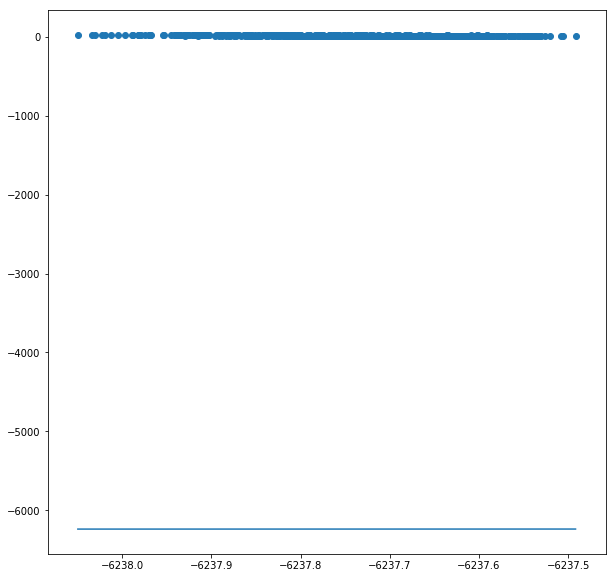

In [14]:
y_image_predict = model.predict([X_image_O, X_image_H])
print(y_image_predict.shape)
parity_plot(y_image,y_image_predict)

In [15]:
adam = keras.optimizers.Adam(lr=0.1)
model.compile(loss = "mse",optimizer=adam)
model.fit([X_image_O, X_image_H], [y_image], nb_epoch=10000,shuffle=True, batch_size=2000)

Instructions for updating:
Use tf.cast instead.


C:\Users\Xiangyun\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10000
794/794 [==============================] - 0s 617us/step - loss: 39097812.0000
Epoch 2/10000
794/794 [==============================] - 0s 19us/step - loss: 38315404.0000
Epoch 3/10000
794/794 [==============================] - 0s 23us/step - loss: 36354800.0000
Epoch 4/10000
794/794 [==============================] - 0s 23us/step - loss: 33100750.0000
Epoch 5/10000
794/794 [==============================] - 0s 19us/step - loss: 27979096.0000
Epoch 6/10000
794/794 [==============================] - 0s 20us/step - loss: 20904074.0000
Epoch 7/10000
794/794 [==============================] - 0s 23us/step - loss: 12500190.0000
Epoch 8/10000
794/794 [==============================] - 0s 20us/step - loss: 4640461.5000
Epoch 9/10000
794/794 [==============================] - 0s 19us/step - loss: 1384430.6250
Epoch 10/10000
794/794 [==============================] - 0s 18us/step - loss: 7131072.0000
Epoch 11/10000
794/794 [==============================] - 0s 21us/step - loss: 11

Epoch 91/10000
794/794 [==============================] - 0s 20us/step - loss: 371136.6562
Epoch 92/10000
794/794 [==============================] - 0s 19us/step - loss: 357449.2812
Epoch 93/10000
794/794 [==============================] - 0s 29us/step - loss: 343607.3750
Epoch 94/10000
794/794 [==============================] - 0s 20us/step - loss: 330689.9688
Epoch 95/10000
794/794 [==============================] - 0s 19us/step - loss: 318871.0938
Epoch 96/10000
794/794 [==============================] - 0s 19us/step - loss: 307412.7812
Epoch 97/10000
794/794 [==============================] - 0s 20us/step - loss: 295490.5312
Epoch 98/10000
794/794 [==============================] - 0s 21us/step - loss: 282979.6562
Epoch 99/10000
794/794 [==============================] - 0s 19us/step - loss: 270469.4375
Epoch 100/10000
794/794 [==============================] - 0s 19us/step - loss: 258603.3906
Epoch 101/10000
794/794 [==============================] - 0s 18us/step - loss: 247474.64

Epoch 182/10000
794/794 [==============================] - 0s 21us/step - loss: 3890.8596
Epoch 183/10000
794/794 [==============================] - 0s 21us/step - loss: 3842.6877
Epoch 184/10000
794/794 [==============================] - 0s 24us/step - loss: 3797.8291
Epoch 185/10000
794/794 [==============================] - 0s 19us/step - loss: 3755.4348
Epoch 186/10000
794/794 [==============================] - 0s 21us/step - loss: 3714.8779
Epoch 187/10000
794/794 [==============================] - 0s 19us/step - loss: 3675.7007
Epoch 188/10000
794/794 [==============================] - 0s 19us/step - loss: 3637.2434
Epoch 189/10000
794/794 [==============================] - 0s 19us/step - loss: 3599.1655
Epoch 190/10000
794/794 [==============================] - 0s 20us/step - loss: 3561.3379
Epoch 191/10000
794/794 [==============================] - 0s 19us/step - loss: 3523.6077
Epoch 192/10000
794/794 [==============================] - 0s 20us/step - loss: 3485.9043
Epoch 193/

794/794 [==============================] - 0s 21us/step - loss: 1970.3376
Epoch 274/10000
794/794 [==============================] - 0s 18us/step - loss: 1962.3317
Epoch 275/10000
794/794 [==============================] - 0s 18us/step - loss: 1954.4668
Epoch 276/10000
794/794 [==============================] - 0s 19us/step - loss: 1946.7169
Epoch 277/10000
794/794 [==============================] - 0s 20us/step - loss: 1939.0935
Epoch 278/10000
794/794 [==============================] - 0s 20us/step - loss: 1931.5914
Epoch 279/10000
794/794 [==============================] - 0s 28us/step - loss: 1924.2137
Epoch 280/10000
794/794 [==============================] - 0s 18us/step - loss: 1916.9375
Epoch 281/10000
794/794 [==============================] - 0s 19us/step - loss: 1909.7754
Epoch 282/10000
794/794 [==============================] - 0s 20us/step - loss: 1902.7355
Epoch 283/10000
794/794 [==============================] - 0s 19us/step - loss: 1895.8031
Epoch 284/10000
794/794 [=

Epoch 365/10000
794/794 [==============================] - 0s 19us/step - loss: 1564.4636
Epoch 366/10000
794/794 [==============================] - 0s 20us/step - loss: 1562.0153
Epoch 367/10000
794/794 [==============================] - 0s 19us/step - loss: 1559.5825
Epoch 368/10000
794/794 [==============================] - 0s 19us/step - loss: 1557.1685
Epoch 369/10000
794/794 [==============================] - 0s 18us/step - loss: 1554.7740
Epoch 370/10000
794/794 [==============================] - 0s 19us/step - loss: 1552.3934
Epoch 371/10000
794/794 [==============================] - 0s 20us/step - loss: 1550.0243
Epoch 372/10000
794/794 [==============================] - 0s 18us/step - loss: 1547.6782
Epoch 373/10000
794/794 [==============================] - 0s 21us/step - loss: 1545.3479
Epoch 374/10000
794/794 [==============================] - 0s 19us/step - loss: 1543.0333
Epoch 375/10000
794/794 [==============================] - 0s 19us/step - loss: 1540.7290
Epoch 376/

794/794 [==============================] - 0s 21us/step - loss: 1381.8081
Epoch 457/10000
794/794 [==============================] - 0s 20us/step - loss: 1380.0249
Epoch 458/10000
794/794 [==============================] - 0s 20us/step - loss: 1378.2388
Epoch 459/10000
794/794 [==============================] - 0s 20us/step - loss: 1376.4554
Epoch 460/10000
794/794 [==============================] - 0s 20us/step - loss: 1374.6750
Epoch 461/10000
794/794 [==============================] - 0s 20us/step - loss: 1372.8962
Epoch 462/10000
794/794 [==============================] - 0s 20us/step - loss: 1371.1239
Epoch 463/10000
794/794 [==============================] - 0s 21us/step - loss: 1369.3495
Epoch 464/10000
794/794 [==============================] - 0s 19us/step - loss: 1367.5825
Epoch 465/10000
794/794 [==============================] - 0s 19us/step - loss: 1365.8132
Epoch 466/10000
794/794 [==============================] - 0s 19us/step - loss: 1364.0488
Epoch 467/10000
794/794 [=

Epoch 548/10000
794/794 [==============================] - 0s 20us/step - loss: 1226.0737
Epoch 549/10000
794/794 [==============================] - 0s 19us/step - loss: 1224.4735
Epoch 550/10000
794/794 [==============================] - 0s 19us/step - loss: 1222.8788
Epoch 551/10000
794/794 [==============================] - 0s 21us/step - loss: 1221.2802
Epoch 552/10000
794/794 [==============================] - 0s 21us/step - loss: 1219.6846
Epoch 553/10000
794/794 [==============================] - 0s 19us/step - loss: 1218.0913
Epoch 554/10000
794/794 [==============================] - 0s 20us/step - loss: 1216.4999
Epoch 555/10000
794/794 [==============================] - 0s 19us/step - loss: 1214.9105
Epoch 556/10000
794/794 [==============================] - 0s 18us/step - loss: 1213.3226
Epoch 557/10000
794/794 [==============================] - 0s 24us/step - loss: 1211.7343
Epoch 558/10000
794/794 [==============================] - 0s 23us/step - loss: 1210.1530
Epoch 559/

794/794 [==============================] - 0s 19us/step - loss: 1087.8397
Epoch 640/10000
794/794 [==============================] - 0s 21us/step - loss: 1086.4083
Epoch 641/10000
794/794 [==============================] - 0s 20us/step - loss: 1084.9764
Epoch 642/10000
794/794 [==============================] - 0s 20us/step - loss: 1083.5464
Epoch 643/10000
794/794 [==============================] - 0s 20us/step - loss: 1082.1189
Epoch 644/10000
794/794 [==============================] - 0s 21us/step - loss: 1080.6949
Epoch 645/10000
794/794 [==============================] - 0s 20us/step - loss: 1079.2722
Epoch 646/10000
794/794 [==============================] - 0s 19us/step - loss: 1077.8503
Epoch 647/10000
794/794 [==============================] - 0s 29us/step - loss: 1076.4301
Epoch 648/10000
794/794 [==============================] - 0s 20us/step - loss: 1075.0127
Epoch 649/10000
794/794 [==============================] - 0s 20us/step - loss: 1073.5969
Epoch 650/10000
794/794 [=

Epoch 731/10000
794/794 [==============================] - 0s 19us/step - loss: 964.1305
Epoch 732/10000
794/794 [==============================] - 0s 23us/step - loss: 962.8766
Epoch 733/10000
794/794 [==============================] - 0s 20us/step - loss: 961.6274
Epoch 734/10000
794/794 [==============================] - 0s 20us/step - loss: 960.3793
Epoch 735/10000
794/794 [==============================] - 0s 20us/step - loss: 959.1346
Epoch 736/10000
794/794 [==============================] - 0s 21us/step - loss: 957.8904
Epoch 737/10000
794/794 [==============================] - 0s 20us/step - loss: 956.6465
Epoch 738/10000
794/794 [==============================] - 0s 19us/step - loss: 955.4058
Epoch 739/10000
794/794 [==============================] - 0s 19us/step - loss: 954.1671
Epoch 740/10000
794/794 [==============================] - 0s 18us/step - loss: 952.9316
Epoch 741/10000
794/794 [==============================] - 0s 19us/step - loss: 951.6961
Epoch 742/10000
794/7

794/794 [==============================] - 0s 20us/step - loss: 857.4235
Epoch 824/10000
794/794 [==============================] - 0s 19us/step - loss: 856.3591
Epoch 825/10000
794/794 [==============================] - 0s 19us/step - loss: 855.2957
Epoch 826/10000
794/794 [==============================] - 0s 20us/step - loss: 854.2352
Epoch 827/10000
794/794 [==============================] - 0s 20us/step - loss: 853.1763
Epoch 828/10000
794/794 [==============================] - 0s 19us/step - loss: 852.1208
Epoch 829/10000
794/794 [==============================] - 0s 19us/step - loss: 851.0642
Epoch 830/10000
794/794 [==============================] - 0s 21us/step - loss: 850.0110
Epoch 831/10000
794/794 [==============================] - 0s 19us/step - loss: 848.9611
Epoch 832/10000
794/794 [==============================] - 0s 19us/step - loss: 847.9123
Epoch 833/10000
794/794 [==============================] - 0s 20us/step - loss: 846.8646
Epoch 834/10000
794/794 [============

Epoch 916/10000
794/794 [==============================] - 0s 19us/step - loss: 766.9108
Epoch 917/10000
794/794 [==============================] - 0s 20us/step - loss: 766.0313
Epoch 918/10000
794/794 [==============================] - 0s 19us/step - loss: 765.1511
Epoch 919/10000
794/794 [==============================] - 0s 18us/step - loss: 764.2720
Epoch 920/10000
794/794 [==============================] - 0s 20us/step - loss: 763.3959
Epoch 921/10000
794/794 [==============================] - 0s 20us/step - loss: 762.5237
Epoch 922/10000
794/794 [==============================] - 0s 19us/step - loss: 761.6511
Epoch 923/10000
794/794 [==============================] - 0s 20us/step - loss: 760.7823
Epoch 924/10000
794/794 [==============================] - 0s 19us/step - loss: 759.9152
Epoch 925/10000
794/794 [==============================] - 0s 20us/step - loss: 759.0470
Epoch 926/10000
794/794 [==============================] - 0s 21us/step - loss: 758.1848
Epoch 927/10000
794/7

Epoch 1008/10000
794/794 [==============================] - 0s 24us/step - loss: 693.5171
Epoch 1009/10000
794/794 [==============================] - 0s 23us/step - loss: 692.8015
Epoch 1010/10000
794/794 [==============================] - 0s 21us/step - loss: 692.0878
Epoch 1011/10000
794/794 [==============================] - 0s 25us/step - loss: 691.3767
Epoch 1012/10000
794/794 [==============================] - 0s 23us/step - loss: 690.6667
Epoch 1013/10000
794/794 [==============================] - 0s 21us/step - loss: 689.9567
Epoch 1014/10000
794/794 [==============================] - 0s 23us/step - loss: 689.2497
Epoch 1015/10000
794/794 [==============================] - 0s 19us/step - loss: 688.5446
Epoch 1016/10000
794/794 [==============================] - 0s 23us/step - loss: 687.8410
Epoch 1017/10000
794/794 [==============================] - 0s 20us/step - loss: 687.1388
Epoch 1018/10000
794/794 [==============================] - 0s 25us/step - loss: 686.4390
Epoch 1019

794/794 [==============================] - 0s 25us/step - loss: 635.0053
Epoch 1100/10000
794/794 [==============================] - 0s 24us/step - loss: 634.4318
Epoch 1101/10000
794/794 [==============================] - 0s 26us/step - loss: 633.8603
Epoch 1102/10000
794/794 [==============================] - 0s 23us/step - loss: 633.2910
Epoch 1103/10000
794/794 [==============================] - 0s 23us/step - loss: 632.7208
Epoch 1104/10000
794/794 [==============================] - 0s 20us/step - loss: 632.1548
Epoch 1105/10000
794/794 [==============================] - 0s 19us/step - loss: 631.5891
Epoch 1106/10000
794/794 [==============================] - 0s 19us/step - loss: 631.0238
Epoch 1107/10000
794/794 [==============================] - 0s 19us/step - loss: 630.4619
Epoch 1108/10000
794/794 [==============================] - 0s 20us/step - loss: 629.9000
Epoch 1109/10000
794/794 [==============================] - 0s 19us/step - loss: 629.3399
Epoch 1110/10000
794/794 [=

Epoch 1191/10000
794/794 [==============================] - 0s 23us/step - loss: 587.8077
Epoch 1192/10000
794/794 [==============================] - 0s 24us/step - loss: 587.3508
Epoch 1193/10000
794/794 [==============================] - 0s 21us/step - loss: 586.8945
Epoch 1194/10000
794/794 [==============================] - 0s 21us/step - loss: 586.4403
Epoch 1195/10000
794/794 [==============================] - 0s 20us/step - loss: 585.9881
Epoch 1196/10000
794/794 [==============================] - 0s 23us/step - loss: 585.5347
Epoch 1197/10000
794/794 [==============================] - 0s 20us/step - loss: 585.0850
Epoch 1198/10000
794/794 [==============================] - 0s 23us/step - loss: 584.6340
Epoch 1199/10000
794/794 [==============================] - 0s 20us/step - loss: 584.1859
Epoch 1200/10000
794/794 [==============================] - 0s 19us/step - loss: 583.7375
Epoch 1201/10000
794/794 [==============================] - 0s 23us/step - loss: 583.2903
Epoch 1202

794/794 [==============================] - 0s 21us/step - loss: 550.4380
Epoch 1283/10000
794/794 [==============================] - 0s 23us/step - loss: 550.0698
Epoch 1284/10000
794/794 [==============================] - 0s 21us/step - loss: 549.7021
Epoch 1285/10000
794/794 [==============================] - 0s 20us/step - loss: 549.3367
Epoch 1286/10000
794/794 [==============================] - 0s 19us/step - loss: 548.9691
Epoch 1287/10000
794/794 [==============================] - 0s 19us/step - loss: 548.6060
Epoch 1288/10000
794/794 [==============================] - 0s 19us/step - loss: 548.2410
Epoch 1289/10000
794/794 [==============================] - 0s 19us/step - loss: 547.8783
Epoch 1290/10000
794/794 [==============================] - 0s 18us/step - loss: 547.5172
Epoch 1291/10000
794/794 [==============================] - 0s 21us/step - loss: 547.1555
Epoch 1292/10000
794/794 [==============================] - 0s 19us/step - loss: 546.7960
Epoch 1293/10000
794/794 [=

Epoch 1374/10000
794/794 [==============================] - 0s 19us/step - loss: 519.8724
Epoch 1375/10000
794/794 [==============================] - 0s 19us/step - loss: 519.5733
Epoch 1376/10000
794/794 [==============================] - 0s 19us/step - loss: 519.2736
Epoch 1377/10000
794/794 [==============================] - 0s 21us/step - loss: 518.9763
Epoch 1378/10000
794/794 [==============================] - 0s 19us/step - loss: 518.6783
Epoch 1379/10000
794/794 [==============================] - 0s 21us/step - loss: 518.3821
Epoch 1380/10000
794/794 [==============================] - 0s 20us/step - loss: 518.0853
Epoch 1381/10000
794/794 [==============================] - 0s 21us/step - loss: 517.7897
Epoch 1382/10000
794/794 [==============================] - 0s 18us/step - loss: 517.4941
Epoch 1383/10000
794/794 [==============================] - 0s 18us/step - loss: 517.2005
Epoch 1384/10000
794/794 [==============================] - 0s 19us/step - loss: 516.9067
Epoch 1385

794/794 [==============================] - 0s 18us/step - loss: 494.8263
Epoch 1466/10000
794/794 [==============================] - 0s 18us/step - loss: 494.5734
Epoch 1467/10000
794/794 [==============================] - 0s 20us/step - loss: 494.3189
Epoch 1468/10000
794/794 [==============================] - 0s 23us/step - loss: 494.0667
Epoch 1469/10000
794/794 [==============================] - 0s 20us/step - loss: 493.8140
Epoch 1470/10000
794/794 [==============================] - 0s 18us/step - loss: 493.5626
Epoch 1471/10000
794/794 [==============================] - 0s 19us/step - loss: 493.3099
Epoch 1472/10000
794/794 [==============================] - 0s 21us/step - loss: 493.0599
Epoch 1473/10000
794/794 [==============================] - 0s 19us/step - loss: 492.8091
Epoch 1474/10000
794/794 [==============================] - 0s 19us/step - loss: 492.5592
Epoch 1475/10000
794/794 [==============================] - 0s 20us/step - loss: 492.3084
Epoch 1476/10000
794/794 [=

Epoch 1557/10000
794/794 [==============================] - 0s 21us/step - loss: 473.2276
Epoch 1558/10000
794/794 [==============================] - 0s 23us/step - loss: 473.0099
Epoch 1559/10000
794/794 [==============================] - 0s 19us/step - loss: 472.7936
Epoch 1560/10000
794/794 [==============================] - 0s 25us/step - loss: 472.5757
Epoch 1561/10000
794/794 [==============================] - 0s 24us/step - loss: 472.3595
Epoch 1562/10000
794/794 [==============================] - 0s 19us/step - loss: 472.1421
Epoch 1563/10000
794/794 [==============================] - 0s 21us/step - loss: 471.9269
Epoch 1564/10000
794/794 [==============================] - 0s 20us/step - loss: 471.7110
Epoch 1565/10000
794/794 [==============================] - 0s 20us/step - loss: 471.4955
Epoch 1566/10000
794/794 [==============================] - 0s 19us/step - loss: 471.2788
Epoch 1567/10000
794/794 [==============================] - 0s 20us/step - loss: 471.0639
Epoch 1568

794/794 [==============================] - 0s 19us/step - loss: 454.5412
Epoch 1649/10000
794/794 [==============================] - 0s 18us/step - loss: 454.3479
Epoch 1650/10000
794/794 [==============================] - 0s 20us/step - loss: 454.1517
Epoch 1651/10000
794/794 [==============================] - 0s 21us/step - loss: 453.9596
Epoch 1652/10000
794/794 [==============================] - 0s 18us/step - loss: 453.7664
Epoch 1653/10000
794/794 [==============================] - 0s 18us/step - loss: 453.5735
Epoch 1654/10000
794/794 [==============================] - 0s 19us/step - loss: 453.3810
Epoch 1655/10000
794/794 [==============================] - 0s 18us/step - loss: 453.1886
Epoch 1656/10000
794/794 [==============================] - 0s 20us/step - loss: 452.9971
Epoch 1657/10000
794/794 [==============================] - 0s 19us/step - loss: 452.8056
Epoch 1658/10000
794/794 [==============================] - 0s 19us/step - loss: 452.6132
Epoch 1659/10000
794/794 [=

Epoch 1740/10000
794/794 [==============================] - 0s 20us/step - loss: 437.6649
Epoch 1741/10000
794/794 [==============================] - 0s 19us/step - loss: 437.4900
Epoch 1742/10000
794/794 [==============================] - 0s 19us/step - loss: 437.3145
Epoch 1743/10000
794/794 [==============================] - 0s 20us/step - loss: 437.1391
Epoch 1744/10000
794/794 [==============================] - 0s 21us/step - loss: 436.9640
Epoch 1745/10000
794/794 [==============================] - 0s 19us/step - loss: 436.7890
Epoch 1746/10000
794/794 [==============================] - 0s 20us/step - loss: 436.6142
Epoch 1747/10000
794/794 [==============================] - 0s 19us/step - loss: 436.4394
Epoch 1748/10000
794/794 [==============================] - 0s 19us/step - loss: 436.2658
Epoch 1749/10000
794/794 [==============================] - 0s 20us/step - loss: 436.0909
Epoch 1750/10000
794/794 [==============================] - 0s 21us/step - loss: 435.9161
Epoch 1751

794/794 [==============================] - 0s 20us/step - loss: 422.3159
Epoch 1832/10000
794/794 [==============================] - 0s 23us/step - loss: 422.1530
Epoch 1833/10000
794/794 [==============================] - 0s 21us/step - loss: 421.9924
Epoch 1834/10000
794/794 [==============================] - 0s 23us/step - loss: 421.8294
Epoch 1835/10000
794/794 [==============================] - 0s 21us/step - loss: 421.6696
Epoch 1836/10000
794/794 [==============================] - 0s 19us/step - loss: 421.5063
Epoch 1837/10000
794/794 [==============================] - 0s 19us/step - loss: 421.3459
Epoch 1838/10000
794/794 [==============================] - 0s 19us/step - loss: 421.1827
Epoch 1839/10000
794/794 [==============================] - 0s 20us/step - loss: 421.0235
Epoch 1840/10000
794/794 [==============================] - 0s 19us/step - loss: 420.8620
Epoch 1841/10000
794/794 [==============================] - 0s 16us/step - loss: 420.7014
Epoch 1842/10000
794/794 [=

Epoch 1923/10000
794/794 [==============================] - 0s 20us/step - loss: 407.9168
Epoch 1924/10000
794/794 [==============================] - 0s 18us/step - loss: 407.7641
Epoch 1925/10000
794/794 [==============================] - 0s 18us/step - loss: 407.6128
Epoch 1926/10000
794/794 [==============================] - 0s 20us/step - loss: 407.4621
Epoch 1927/10000
794/794 [==============================] - 0s 19us/step - loss: 407.3107
Epoch 1928/10000
794/794 [==============================] - 0s 21us/step - loss: 407.1575
Epoch 1929/10000
794/794 [==============================] - 0s 18us/step - loss: 407.0077
Epoch 1930/10000
794/794 [==============================] - 0s 18us/step - loss: 406.8559
Epoch 1931/10000
794/794 [==============================] - 0s 19us/step - loss: 406.7055
Epoch 1932/10000
794/794 [==============================] - 0s 20us/step - loss: 406.5551
Epoch 1933/10000
794/794 [==============================] - 0s 25us/step - loss: 406.4042
Epoch 1934

794/794 [==============================] - 0s 19us/step - loss: 394.5458
Epoch 2015/10000
794/794 [==============================] - 0s 19us/step - loss: 394.4031
Epoch 2016/10000
794/794 [==============================] - 0s 20us/step - loss: 394.2613
Epoch 2017/10000
794/794 [==============================] - 0s 20us/step - loss: 394.1189
Epoch 2018/10000
794/794 [==============================] - 0s 19us/step - loss: 393.9767
Epoch 2019/10000
794/794 [==============================] - 0s 21us/step - loss: 393.8352
Epoch 2020/10000
794/794 [==============================] - 0s 19us/step - loss: 393.6932
Epoch 2021/10000
794/794 [==============================] - 0s 19us/step - loss: 393.5516
Epoch 2022/10000
794/794 [==============================] - 0s 19us/step - loss: 393.4090
Epoch 2023/10000
794/794 [==============================] - 0s 23us/step - loss: 393.2684
Epoch 2024/10000
794/794 [==============================] - 0s 20us/step - loss: 393.1261
Epoch 2025/10000
794/794 [=

Epoch 2106/10000
794/794 [==============================] - 0s 20us/step - loss: 381.7733
Epoch 2107/10000
794/794 [==============================] - 0s 20us/step - loss: 381.6376
Epoch 2108/10000
794/794 [==============================] - 0s 18us/step - loss: 381.5025
Epoch 2109/10000
794/794 [==============================] - 0s 20us/step - loss: 381.3662
Epoch 2110/10000
794/794 [==============================] - 0s 18us/step - loss: 381.2315
Epoch 2111/10000
794/794 [==============================] - 0s 19us/step - loss: 381.0948
Epoch 2112/10000
794/794 [==============================] - 0s 19us/step - loss: 380.9599
Epoch 2113/10000
794/794 [==============================] - 0s 18us/step - loss: 380.8241
Epoch 2114/10000
794/794 [==============================] - 0s 16us/step - loss: 380.6890
Epoch 2115/10000
794/794 [==============================] - 0s 18us/step - loss: 380.5529
Epoch 2116/10000
794/794 [==============================] - 0s 20us/step - loss: 380.4172
Epoch 2117

794/794 [==============================] - 0s 20us/step - loss: 369.6541
Epoch 2198/10000
794/794 [==============================] - 0s 19us/step - loss: 369.5242
Epoch 2199/10000
794/794 [==============================] - 0s 19us/step - loss: 369.3936
Epoch 2200/10000
794/794 [==============================] - 0s 20us/step - loss: 369.2623
Epoch 2201/10000
794/794 [==============================] - 0s 18us/step - loss: 369.1329
Epoch 2202/10000
794/794 [==============================] - 0s 20us/step - loss: 369.0023
Epoch 2203/10000
794/794 [==============================] - 0s 20us/step - loss: 368.8716
Epoch 2204/10000
794/794 [==============================] - 0s 20us/step - loss: 368.7417
Epoch 2205/10000
794/794 [==============================] - 0s 21us/step - loss: 368.6115
Epoch 2206/10000
794/794 [==============================] - 0s 19us/step - loss: 368.4819
Epoch 2207/10000
794/794 [==============================] - 0s 21us/step - loss: 368.3510
Epoch 2208/10000
794/794 [=

Epoch 2289/10000
794/794 [==============================] - 0s 19us/step - loss: 357.8895
Epoch 2290/10000
794/794 [==============================] - 0s 29us/step - loss: 357.7648
Epoch 2291/10000
794/794 [==============================] - 0s 20us/step - loss: 357.6390
Epoch 2292/10000
794/794 [==============================] - 0s 18us/step - loss: 357.5137
Epoch 2293/10000
794/794 [==============================] - 0s 19us/step - loss: 357.3898
Epoch 2294/10000
794/794 [==============================] - 0s 20us/step - loss: 357.2634
Epoch 2295/10000
794/794 [==============================] - 0s 20us/step - loss: 357.1390
Epoch 2296/10000
794/794 [==============================] - 0s 19us/step - loss: 357.0134
Epoch 2297/10000
794/794 [==============================] - 0s 18us/step - loss: 356.8882
Epoch 2298/10000
794/794 [==============================] - 0s 23us/step - loss: 356.7644
Epoch 2299/10000
794/794 [==============================] - 0s 19us/step - loss: 356.6400
Epoch 2300

794/794 [==============================] - 0s 21us/step - loss: 346.6312
Epoch 2381/10000
794/794 [==============================] - 0s 20us/step - loss: 346.5097
Epoch 2382/10000
794/794 [==============================] - 0s 21us/step - loss: 346.3866
Epoch 2383/10000
794/794 [==============================] - 0s 19us/step - loss: 346.2653
Epoch 2384/10000
794/794 [==============================] - 0s 21us/step - loss: 346.1428
Epoch 2385/10000
794/794 [==============================] - 0s 21us/step - loss: 346.0219
Epoch 2386/10000
794/794 [==============================] - 0s 19us/step - loss: 345.9000
Epoch 2387/10000
794/794 [==============================] - 0s 19us/step - loss: 345.7779
Epoch 2388/10000
794/794 [==============================] - 0s 21us/step - loss: 345.6570
Epoch 2389/10000
794/794 [==============================] - 0s 19us/step - loss: 345.5352
Epoch 2390/10000
794/794 [==============================] - 0s 20us/step - loss: 345.4141
Epoch 2391/10000
794/794 [=

Epoch 2472/10000
794/794 [==============================] - 0s 24us/step - loss: 335.6037
Epoch 2473/10000
794/794 [==============================] - 0s 21us/step - loss: 335.4860
Epoch 2474/10000
794/794 [==============================] - 0s 20us/step - loss: 335.3681
Epoch 2475/10000
794/794 [==============================] - 0s 28us/step - loss: 335.2502
Epoch 2476/10000
794/794 [==============================] - 0s 23us/step - loss: 335.1323
Epoch 2477/10000
794/794 [==============================] - 0s 18us/step - loss: 335.0146
Epoch 2478/10000
794/794 [==============================] - 0s 24us/step - loss: 334.8962
Epoch 2479/10000
794/794 [==============================] - 0s 21us/step - loss: 334.7781
Epoch 2480/10000
794/794 [==============================] - 0s 21us/step - loss: 334.6599
Epoch 2481/10000
794/794 [==============================] - 0s 20us/step - loss: 334.5422
Epoch 2482/10000
794/794 [==============================] - 0s 20us/step - loss: 334.4244
Epoch 2483

794/794 [==============================] - 0s 21us/step - loss: 324.9961
Epoch 2564/10000
794/794 [==============================] - 0s 21us/step - loss: 324.8823
Epoch 2565/10000
794/794 [==============================] - 0s 20us/step - loss: 324.7663
Epoch 2566/10000
794/794 [==============================] - 0s 19us/step - loss: 324.6512
Epoch 2567/10000
794/794 [==============================] - 0s 19us/step - loss: 324.5381
Epoch 2568/10000
794/794 [==============================] - 0s 20us/step - loss: 324.4216
Epoch 2569/10000
794/794 [==============================] - 0s 19us/step - loss: 324.3073
Epoch 2570/10000
794/794 [==============================] - 0s 19us/step - loss: 324.1921
Epoch 2571/10000
794/794 [==============================] - 0s 19us/step - loss: 324.0781
Epoch 2572/10000
794/794 [==============================] - 0s 19us/step - loss: 323.9626
Epoch 2573/10000
794/794 [==============================] - 0s 21us/step - loss: 323.8490
Epoch 2574/10000
794/794 [=

Epoch 2655/10000
794/794 [==============================] - 0s 20us/step - loss: 314.5441
Epoch 2656/10000
794/794 [==============================] - 0s 20us/step - loss: 314.4311
Epoch 2657/10000
794/794 [==============================] - 0s 21us/step - loss: 314.3202
Epoch 2658/10000
794/794 [==============================] - 0s 19us/step - loss: 314.2069
Epoch 2659/10000
794/794 [==============================] - 0s 18us/step - loss: 314.0943
Epoch 2660/10000
794/794 [==============================] - 0s 19us/step - loss: 313.9818
Epoch 2661/10000
794/794 [==============================] - 0s 18us/step - loss: 313.8711
Epoch 2662/10000
794/794 [==============================] - 0s 18us/step - loss: 313.7575
Epoch 2663/10000
794/794 [==============================] - 0s 19us/step - loss: 313.6449
Epoch 2664/10000
794/794 [==============================] - 0s 18us/step - loss: 313.5328
Epoch 2665/10000
794/794 [==============================] - 0s 20us/step - loss: 313.4204
Epoch 2666

794/794 [==============================] - 0s 19us/step - loss: 304.4187
Epoch 2747/10000
794/794 [==============================] - 0s 20us/step - loss: 304.3099
Epoch 2748/10000
794/794 [==============================] - 0s 19us/step - loss: 304.1996
Epoch 2749/10000
794/794 [==============================] - 0s 19us/step - loss: 304.0888
Epoch 2750/10000
794/794 [==============================] - 0s 19us/step - loss: 303.9801
Epoch 2751/10000
794/794 [==============================] - 0s 19us/step - loss: 303.8690
Epoch 2752/10000
794/794 [==============================] - 0s 19us/step - loss: 303.7594
Epoch 2753/10000
794/794 [==============================] - 0s 20us/step - loss: 303.6490
Epoch 2754/10000
794/794 [==============================] - 0s 20us/step - loss: 303.5394
Epoch 2755/10000
794/794 [==============================] - 0s 19us/step - loss: 303.4308
Epoch 2756/10000
794/794 [==============================] - 0s 18us/step - loss: 303.3202
Epoch 2757/10000
794/794 [=

Epoch 2838/10000
794/794 [==============================] - 0s 26us/step - loss: 6300.3701
Epoch 2839/10000
794/794 [==============================] - 0s 19us/step - loss: 11089.8057
Epoch 2840/10000
794/794 [==============================] - 0s 21us/step - loss: 18093.1504
Epoch 2841/10000
794/794 [==============================] - 0s 21us/step - loss: 31449.7227
Epoch 2842/10000
794/794 [==============================] - 0s 20us/step - loss: 45584.5625
Epoch 2843/10000
794/794 [==============================] - 0s 20us/step - loss: 69599.8594
Epoch 2844/10000
794/794 [==============================] - 0s 20us/step - loss: 73522.2578
Epoch 2845/10000
794/794 [==============================] - 0s 19us/step - loss: 73707.5703
Epoch 2846/10000
794/794 [==============================] - 0s 19us/step - loss: 38534.0898
Epoch 2847/10000
794/794 [==============================] - 0s 19us/step - loss: 9465.7598
Epoch 2848/10000
794/794 [==============================] - 0s 21us/step - loss: 1

Epoch 2929/10000
794/794 [==============================] - 0s 19us/step - loss: 293.5100
Epoch 2930/10000
794/794 [==============================] - 0s 25us/step - loss: 297.9341
Epoch 2931/10000
794/794 [==============================] - 0s 21us/step - loss: 300.1360
Epoch 2932/10000
794/794 [==============================] - 0s 21us/step - loss: 297.9994
Epoch 2933/10000
794/794 [==============================] - 0s 18us/step - loss: 293.7841
Epoch 2934/10000
794/794 [==============================] - 0s 19us/step - loss: 291.1351
Epoch 2935/10000
794/794 [==============================] - 0s 19us/step - loss: 291.6671
Epoch 2936/10000
794/794 [==============================] - 0s 19us/step - loss: 293.9458
Epoch 2937/10000
794/794 [==============================] - 0s 20us/step - loss: 295.3340
Epoch 2938/10000
794/794 [==============================] - 0s 19us/step - loss: 294.5126
Epoch 2939/10000
794/794 [==============================] - 0s 19us/step - loss: 292.3002
Epoch 2940

794/794 [==============================] - 0s 24us/step - loss: 282.4785
Epoch 3021/10000
794/794 [==============================] - 0s 26us/step - loss: 282.3822
Epoch 3022/10000
794/794 [==============================] - 0s 31us/step - loss: 282.2856
Epoch 3023/10000
794/794 [==============================] - 0s 21us/step - loss: 282.1890
Epoch 3024/10000
794/794 [==============================] - 0s 21us/step - loss: 282.0921
Epoch 3025/10000
794/794 [==============================] - 0s 25us/step - loss: 281.9954
Epoch 3026/10000
794/794 [==============================] - 0s 30us/step - loss: 281.8977
Epoch 3027/10000
794/794 [==============================] - 0s 24us/step - loss: 281.8009
Epoch 3028/10000
794/794 [==============================] - 0s 19us/step - loss: 281.7039
Epoch 3029/10000
794/794 [==============================] - 0s 19us/step - loss: 281.6064
Epoch 3030/10000
794/794 [==============================] - 0s 18us/step - loss: 281.5099
Epoch 3031/10000
794/794 [=

794/794 [==============================] - 0s 20us/step - loss: 4346.7700
Epoch 3112/10000
794/794 [==============================] - 0s 23us/step - loss: 7165.0288
Epoch 3113/10000
794/794 [==============================] - 0s 20us/step - loss: 12588.1016
Epoch 3114/10000
794/794 [==============================] - 0s 19us/step - loss: 20206.0410
Epoch 3115/10000
794/794 [==============================] - 0s 20us/step - loss: 34974.9102
Epoch 3116/10000
794/794 [==============================] - 0s 19us/step - loss: 49584.1250
Epoch 3117/10000
794/794 [==============================] - 0s 16us/step - loss: 75460.8047
Epoch 3118/10000
794/794 [==============================] - 0s 19us/step - loss: 77682.6016
Epoch 3119/10000
794/794 [==============================] - 0s 18us/step - loss: 77463.3672
Epoch 3120/10000
794/794 [==============================] - 0s 18us/step - loss: 39964.0664
Epoch 3121/10000
794/794 [==============================] - 0s 21us/step - loss: 9949.2969
Epoch 31

Epoch 3202/10000
794/794 [==============================] - 0s 20us/step - loss: 282.6656
Epoch 3203/10000
794/794 [==============================] - 0s 20us/step - loss: 283.3575
Epoch 3204/10000
794/794 [==============================] - 0s 23us/step - loss: 279.0221
Epoch 3205/10000
794/794 [==============================] - 0s 23us/step - loss: 273.4153
Epoch 3206/10000
794/794 [==============================] - 0s 24us/step - loss: 270.6612
Epoch 3207/10000
794/794 [==============================] - 0s 20us/step - loss: 271.8546
Epoch 3208/10000
794/794 [==============================] - 0s 19us/step - loss: 274.8618
Epoch 3209/10000
794/794 [==============================] - 0s 20us/step - loss: 276.6293
Epoch 3210/10000
794/794 [==============================] - 0s 20us/step - loss: 275.6617
Epoch 3211/10000
794/794 [==============================] - 0s 19us/step - loss: 272.8845
Epoch 3212/10000
794/794 [==============================] - 0s 19us/step - loss: 270.4040
Epoch 3213

794/794 [==============================] - 0s 20us/step - loss: 262.4780
Epoch 3294/10000
794/794 [==============================] - 0s 20us/step - loss: 262.3898
Epoch 3295/10000
794/794 [==============================] - 0s 20us/step - loss: 262.3034
Epoch 3296/10000
794/794 [==============================] - 0s 21us/step - loss: 262.2162
Epoch 3297/10000
794/794 [==============================] - 0s 20us/step - loss: 262.1288
Epoch 3298/10000
794/794 [==============================] - 0s 20us/step - loss: 262.0425
Epoch 3299/10000
794/794 [==============================] - 0s 19us/step - loss: 261.9550
Epoch 3300/10000
794/794 [==============================] - 0s 18us/step - loss: 261.8669
Epoch 3301/10000
794/794 [==============================] - 0s 20us/step - loss: 261.7801
Epoch 3302/10000
794/794 [==============================] - 0s 18us/step - loss: 261.6920
Epoch 3303/10000
794/794 [==============================] - 0s 20us/step - loss: 261.6044
Epoch 3304/10000
794/794 [=

Epoch 3384/10000
794/794 [==============================] - 0s 23us/step - loss: 9984.8408
Epoch 3385/10000
794/794 [==============================] - 0s 23us/step - loss: 470.1729
Epoch 3386/10000
794/794 [==============================] - 0s 21us/step - loss: 5228.9946
Epoch 3387/10000
794/794 [==============================] - 0s 21us/step - loss: 15613.0166
Epoch 3388/10000
794/794 [==============================] - 0s 19us/step - loss: 21672.9062
Epoch 3389/10000
794/794 [==============================] - 0s 20us/step - loss: 14624.9268
Epoch 3390/10000
794/794 [==============================] - 0s 19us/step - loss: 5014.5024
Epoch 3391/10000
794/794 [==============================] - 0s 18us/step - loss: 380.0367
Epoch 3392/10000
794/794 [==============================] - 0s 18us/step - loss: 3899.8240
Epoch 3393/10000
794/794 [==============================] - 0s 18us/step - loss: 9813.8320
Epoch 3394/10000
794/794 [==============================] - 0s 19us/step - loss: 9868.986

Epoch 3475/10000
794/794 [==============================] - 0s 21us/step - loss: 252.0649
Epoch 3476/10000
794/794 [==============================] - 0s 23us/step - loss: 251.1176
Epoch 3477/10000
794/794 [==============================] - 0s 21us/step - loss: 251.0351
Epoch 3478/10000
794/794 [==============================] - 0s 23us/step - loss: 251.5686
Epoch 3479/10000
794/794 [==============================] - 0s 31us/step - loss: 252.1795
Epoch 3480/10000
794/794 [==============================] - 0s 20us/step - loss: 252.3986
Epoch 3481/10000
794/794 [==============================] - 0s 25us/step - loss: 252.0875
Epoch 3482/10000
794/794 [==============================] - 0s 24us/step - loss: 251.4162
Epoch 3483/10000
794/794 [==============================] - 0s 25us/step - loss: 250.7289
Epoch 3484/10000
794/794 [==============================] - 0s 23us/step - loss: 250.3066
Epoch 3485/10000
794/794 [==============================] - 0s 24us/step - loss: 250.2421
Epoch 3486

794/794 [==============================] - 0s 21us/step - loss: 243.6510
Epoch 3567/10000
794/794 [==============================] - 0s 23us/step - loss: 243.5706
Epoch 3568/10000
794/794 [==============================] - 0s 23us/step - loss: 243.4915
Epoch 3569/10000
794/794 [==============================] - 0s 24us/step - loss: 243.4126
Epoch 3570/10000
794/794 [==============================] - 0s 19us/step - loss: 243.3329
Epoch 3571/10000
794/794 [==============================] - 0s 24us/step - loss: 243.2534
Epoch 3572/10000
794/794 [==============================] - 0s 24us/step - loss: 243.1744
Epoch 3573/10000
794/794 [==============================] - 0s 21us/step - loss: 243.0952
Epoch 3574/10000
794/794 [==============================] - 0s 19us/step - loss: 243.0176
Epoch 3575/10000
794/794 [==============================] - 0s 18us/step - loss: 242.9393
Epoch 3576/10000
794/794 [==============================] - 0s 23us/step - loss: 242.8627
Epoch 3577/10000
794/794 [=

Epoch 3657/10000
794/794 [==============================] - 0s 19us/step - loss: 688.5818
Epoch 3658/10000
794/794 [==============================] - 0s 21us/step - loss: 333.2123
Epoch 3659/10000
794/794 [==============================] - 0s 19us/step - loss: 308.3896
Epoch 3660/10000
794/794 [==============================] - 0s 20us/step - loss: 542.2235
Epoch 3661/10000
794/794 [==============================] - 0s 20us/step - loss: 747.9316
Epoch 3662/10000
794/794 [==============================] - 0s 18us/step - loss: 711.4831
Epoch 3663/10000
794/794 [==============================] - 0s 19us/step - loss: 500.2907
Epoch 3664/10000
794/794 [==============================] - 0s 20us/step - loss: 306.4016
Epoch 3665/10000
794/794 [==============================] - 0s 19us/step - loss: 281.0247
Epoch 3666/10000
794/794 [==============================] - 0s 23us/step - loss: 396.6928
Epoch 3667/10000
794/794 [==============================] - 0s 20us/step - loss: 509.1915
Epoch 3668

794/794 [==============================] - 0s 20us/step - loss: 232.9656
Epoch 3749/10000
794/794 [==============================] - 0s 23us/step - loss: 232.9082
Epoch 3750/10000
794/794 [==============================] - 0s 30us/step - loss: 232.8464
Epoch 3751/10000
794/794 [==============================] - 0s 47us/step - loss: 232.7732
Epoch 3752/10000
794/794 [==============================] - 0s 35us/step - loss: 232.6920
Epoch 3753/10000
794/794 [==============================] - 0s 34us/step - loss: 232.6062
Epoch 3754/10000
794/794 [==============================] - 0s 28us/step - loss: 232.5159
Epoch 3755/10000
794/794 [==============================] - 0s 30us/step - loss: 232.4262
Epoch 3756/10000
794/794 [==============================] - 0s 26us/step - loss: 232.3363
Epoch 3757/10000
794/794 [==============================] - 0s 33us/step - loss: 232.2503
Epoch 3758/10000
794/794 [==============================] - 0s 33us/step - loss: 232.1683
Epoch 3759/10000
794/794 [=

Epoch 3839/10000
794/794 [==============================] - 0s 19us/step - loss: 27264.2461
Epoch 3840/10000
794/794 [==============================] - 0s 20us/step - loss: 22476.5977
Epoch 3841/10000
794/794 [==============================] - 0s 18us/step - loss: 8963.8193
Epoch 3842/10000
794/794 [==============================] - 0s 21us/step - loss: 960.7606
Epoch 3843/10000
794/794 [==============================] - 0s 20us/step - loss: 2107.2537
Epoch 3844/10000
794/794 [==============================] - 0s 19us/step - loss: 8901.0947
Epoch 3845/10000
794/794 [==============================] - 0s 20us/step - loss: 14996.5146
Epoch 3846/10000
794/794 [==============================] - 0s 18us/step - loss: 13180.5098
Epoch 3847/10000
794/794 [==============================] - 0s 20us/step - loss: 7534.3691
Epoch 3848/10000
794/794 [==============================] - 0s 20us/step - loss: 1610.0730
Epoch 3849/10000
794/794 [==============================] - 0s 19us/step - loss: 636.21

Epoch 3930/10000
794/794 [==============================] - 0s 24us/step - loss: 227.0784
Epoch 3931/10000
794/794 [==============================] - 0s 23us/step - loss: 225.9361
Epoch 3932/10000
794/794 [==============================] - 0s 21us/step - loss: 224.6982
Epoch 3933/10000
794/794 [==============================] - 0s 20us/step - loss: 223.6923
Epoch 3934/10000
794/794 [==============================] - 0s 20us/step - loss: 223.0978
Epoch 3935/10000
794/794 [==============================] - 0s 18us/step - loss: 222.9371
Epoch 3936/10000
794/794 [==============================] - 0s 19us/step - loss: 223.0893
Epoch 3937/10000
794/794 [==============================] - 0s 18us/step - loss: 223.3752
Epoch 3938/10000
794/794 [==============================] - 0s 19us/step - loss: 223.6148
Epoch 3939/10000
794/794 [==============================] - 0s 20us/step - loss: 223.6849
Epoch 3940/10000
794/794 [==============================] - 0s 19us/step - loss: 223.5460
Epoch 3941

Epoch 4021/10000
794/794 [==============================] - 0s 19us/step - loss: 31004.9219
Epoch 4022/10000
794/794 [==============================] - 0s 19us/step - loss: 44515.2305
Epoch 4023/10000
794/794 [==============================] - 0s 19us/step - loss: 47151.9805
Epoch 4024/10000
794/794 [==============================] - 0s 21us/step - loss: 51983.2734
Epoch 4025/10000
794/794 [==============================] - 0s 19us/step - loss: 36837.4492
Epoch 4026/10000
794/794 [==============================] - 0s 19us/step - loss: 21760.5156
Epoch 4027/10000
794/794 [==============================] - 0s 19us/step - loss: 5884.8853
Epoch 4028/10000
794/794 [==============================] - 0s 19us/step - loss: 574.6668
Epoch 4029/10000
794/794 [==============================] - 0s 26us/step - loss: 5618.2305
Epoch 4030/10000
794/794 [==============================] - 0s 21us/step - loss: 14439.4580
Epoch 4031/10000
794/794 [==============================] - 0s 21us/step - loss: 216

Epoch 4112/10000
794/794 [==============================] - 0s 19us/step - loss: 218.6506
Epoch 4113/10000
794/794 [==============================] - 0s 21us/step - loss: 216.3209
Epoch 4114/10000
794/794 [==============================] - 0s 20us/step - loss: 214.8164
Epoch 4115/10000
794/794 [==============================] - 0s 18us/step - loss: 214.1842
Epoch 4116/10000
794/794 [==============================] - 0s 19us/step - loss: 214.2611
Epoch 4117/10000
794/794 [==============================] - 0s 20us/step - loss: 214.7825
Epoch 4118/10000
794/794 [==============================] - 0s 23us/step - loss: 215.4536
Epoch 4119/10000
794/794 [==============================] - 0s 24us/step - loss: 216.0300
Epoch 4120/10000
794/794 [==============================] - 0s 21us/step - loss: 216.3537
Epoch 4121/10000
794/794 [==============================] - 0s 21us/step - loss: 216.3456
Epoch 4122/10000
794/794 [==============================] - 0s 19us/step - loss: 216.0269
Epoch 4123

Epoch 4203/10000
794/794 [==============================] - 0s 20us/step - loss: 594.1078
Epoch 4204/10000
794/794 [==============================] - 0s 19us/step - loss: 1806.5480
Epoch 4205/10000
794/794 [==============================] - 0s 25us/step - loss: 2867.8682
Epoch 4206/10000
794/794 [==============================] - 0s 26us/step - loss: 3178.6997
Epoch 4207/10000
794/794 [==============================] - 0s 20us/step - loss: 2410.0117
Epoch 4208/10000
794/794 [==============================] - 0s 19us/step - loss: 1324.0227
Epoch 4209/10000
794/794 [==============================] - 0s 18us/step - loss: 462.0417
Epoch 4210/10000
794/794 [==============================] - 0s 21us/step - loss: 253.4456
Epoch 4211/10000
794/794 [==============================] - 0s 20us/step - loss: 630.2512
Epoch 4212/10000
794/794 [==============================] - 0s 19us/step - loss: 1207.3788
Epoch 4213/10000
794/794 [==============================] - 0s 19us/step - loss: 1611.6198
Epo

Epoch 4294/10000
794/794 [==============================] - 0s 25us/step - loss: 219.2650
Epoch 4295/10000
794/794 [==============================] - 0s 25us/step - loss: 224.8050
Epoch 4296/10000
794/794 [==============================] - 0s 23us/step - loss: 232.3387
Epoch 4297/10000
794/794 [==============================] - 0s 19us/step - loss: 243.0374
Epoch 4298/10000
794/794 [==============================] - 0s 20us/step - loss: 257.7834
Epoch 4299/10000
794/794 [==============================] - 0s 19us/step - loss: 279.1829
Epoch 4300/10000
794/794 [==============================] - 0s 21us/step - loss: 308.9923
Epoch 4301/10000
794/794 [==============================] - 0s 21us/step - loss: 353.1450
Epoch 4302/10000
794/794 [==============================] - 0s 24us/step - loss: 414.8979
Epoch 4303/10000
794/794 [==============================] - 0s 24us/step - loss: 508.3788
Epoch 4304/10000
794/794 [==============================] - 0s 23us/step - loss: 639.3610
Epoch 4305

Epoch 4385/10000
794/794 [==============================] - 0s 23us/step - loss: 239.7342
Epoch 4386/10000
794/794 [==============================] - 0s 21us/step - loss: 243.9308
Epoch 4387/10000
794/794 [==============================] - 0s 21us/step - loss: 242.7467
Epoch 4388/10000
794/794 [==============================] - 0s 24us/step - loss: 236.6477
Epoch 4389/10000
794/794 [==============================] - 0s 24us/step - loss: 227.8795
Epoch 4390/10000
794/794 [==============================] - 0s 23us/step - loss: 218.2864
Epoch 4391/10000
794/794 [==============================] - 0s 21us/step - loss: 209.9419
Epoch 4392/10000
794/794 [==============================] - 0s 20us/step - loss: 203.9870
Epoch 4393/10000
794/794 [==============================] - 0s 19us/step - loss: 200.8712
Epoch 4394/10000
794/794 [==============================] - 0s 19us/step - loss: 200.3580
Epoch 4395/10000
794/794 [==============================] - 0s 20us/step - loss: 201.7864
Epoch 4396

Epoch 4476/10000
794/794 [==============================] - 0s 20us/step - loss: 4067.4729
Epoch 4477/10000
794/794 [==============================] - 0s 21us/step - loss: 734.4549
Epoch 4478/10000
794/794 [==============================] - 0s 18us/step - loss: 660.2592
Epoch 4479/10000
794/794 [==============================] - 0s 20us/step - loss: 2976.0237
Epoch 4480/10000
794/794 [==============================] - 0s 20us/step - loss: 5176.2925
Epoch 4481/10000
794/794 [==============================] - 0s 20us/step - loss: 4857.6777
Epoch 4482/10000
794/794 [==============================] - 0s 21us/step - loss: 2919.0520
Epoch 4483/10000
794/794 [==============================] - 0s 19us/step - loss: 826.1487
Epoch 4484/10000
794/794 [==============================] - 0s 19us/step - loss: 319.8081
Epoch 4485/10000
794/794 [==============================] - 0s 18us/step - loss: 1341.3658
Epoch 4486/10000
794/794 [==============================] - 0s 19us/step - loss: 2571.2456
Epo

Epoch 4567/10000
794/794 [==============================] - 0s 19us/step - loss: 188.4805
Epoch 4568/10000
794/794 [==============================] - 0s 21us/step - loss: 188.2069
Epoch 4569/10000
794/794 [==============================] - 0s 18us/step - loss: 188.0425
Epoch 4570/10000
794/794 [==============================] - 0s 18us/step - loss: 187.9643
Epoch 4571/10000
794/794 [==============================] - 0s 35us/step - loss: 187.9395
Epoch 4572/10000
794/794 [==============================] - 0s 19us/step - loss: 187.9401
Epoch 4573/10000
794/794 [==============================] - 0s 19us/step - loss: 187.9453
Epoch 4574/10000
794/794 [==============================] - 0s 21us/step - loss: 187.9380
Epoch 4575/10000
794/794 [==============================] - 0s 21us/step - loss: 187.9107
Epoch 4576/10000
794/794 [==============================] - 0s 30us/step - loss: 187.8641
Epoch 4577/10000
794/794 [==============================] - 0s 25us/step - loss: 187.7936
Epoch 4578

Epoch 4658/10000
794/794 [==============================] - 0s 21us/step - loss: 1795.5532
Epoch 4659/10000
794/794 [==============================] - 0s 21us/step - loss: 2293.1931
Epoch 4660/10000
794/794 [==============================] - 0s 20us/step - loss: 1920.9532
Epoch 4661/10000
794/794 [==============================] - 0s 21us/step - loss: 1138.9423
Epoch 4662/10000
794/794 [==============================] - 0s 21us/step - loss: 429.1381
Epoch 4663/10000
794/794 [==============================] - 0s 21us/step - loss: 227.0967
Epoch 4664/10000
794/794 [==============================] - 0s 20us/step - loss: 516.1616
Epoch 4665/10000
794/794 [==============================] - 0s 20us/step - loss: 957.2598
Epoch 4666/10000
794/794 [==============================] - 0s 20us/step - loss: 1208.4080
Epoch 4667/10000
794/794 [==============================] - 0s 20us/step - loss: 1066.3208
Epoch 4668/10000
794/794 [==============================] - 0s 18us/step - loss: 703.9259
Epoc

Epoch 4749/10000
794/794 [==============================] - 0s 21us/step - loss: 179.1136
Epoch 4750/10000
794/794 [==============================] - 0s 19us/step - loss: 179.0474
Epoch 4751/10000
794/794 [==============================] - 0s 21us/step - loss: 179.0078
Epoch 4752/10000
794/794 [==============================] - 0s 19us/step - loss: 178.9973
Epoch 4753/10000
794/794 [==============================] - 0s 20us/step - loss: 179.0235
Epoch 4754/10000
794/794 [==============================] - 0s 20us/step - loss: 179.0892
Epoch 4755/10000
794/794 [==============================] - 0s 19us/step - loss: 179.2027
Epoch 4756/10000
794/794 [==============================] - 0s 20us/step - loss: 179.3806
Epoch 4757/10000
794/794 [==============================] - 0s 20us/step - loss: 179.6431
Epoch 4758/10000
794/794 [==============================] - 0s 18us/step - loss: 180.0152
Epoch 4759/10000
794/794 [==============================] - 0s 21us/step - loss: 180.5469
Epoch 4760

Epoch 4840/10000
794/794 [==============================] - 0s 23us/step - loss: 358.1813
Epoch 4841/10000
794/794 [==============================] - 0s 21us/step - loss: 296.1580
Epoch 4842/10000
794/794 [==============================] - 0s 20us/step - loss: 232.1481
Epoch 4843/10000
794/794 [==============================] - 0s 23us/step - loss: 193.0568
Epoch 4844/10000
794/794 [==============================] - 0s 23us/step - loss: 189.8950
Epoch 4845/10000
794/794 [==============================] - 0s 18us/step - loss: 214.0142
Epoch 4846/10000
794/794 [==============================] - 0s 18us/step - loss: 245.6266
Epoch 4847/10000
794/794 [==============================] - 0s 20us/step - loss: 266.4880
Epoch 4848/10000
794/794 [==============================] - 0s 19us/step - loss: 265.9361
Epoch 4849/10000
794/794 [==============================] - 0s 23us/step - loss: 247.5262
Epoch 4850/10000
794/794 [==============================] - 0s 23us/step - loss: 220.2534
Epoch 4851

Epoch 4931/10000
794/794 [==============================] - 0s 19us/step - loss: 6585.7690
Epoch 4932/10000
794/794 [==============================] - 0s 19us/step - loss: 9281.4482
Epoch 4933/10000
794/794 [==============================] - 0s 19us/step - loss: 14090.9131
Epoch 4934/10000
794/794 [==============================] - 0s 18us/step - loss: 18630.7988
Epoch 4935/10000
794/794 [==============================] - 0s 20us/step - loss: 26764.5195
Epoch 4936/10000
794/794 [==============================] - 0s 19us/step - loss: 30595.2949
Epoch 4937/10000
794/794 [==============================] - 0s 20us/step - loss: 37304.9883
Epoch 4938/10000
794/794 [==============================] - 0s 20us/step - loss: 32591.8184
Epoch 4939/10000
794/794 [==============================] - 0s 21us/step - loss: 27501.5859
Epoch 4940/10000
794/794 [==============================] - 0s 21us/step - loss: 14691.1406
Epoch 4941/10000
794/794 [==============================] - 0s 20us/step - loss: 5

Epoch 5022/10000
794/794 [==============================] - 0s 20us/step - loss: 167.9080
Epoch 5023/10000
794/794 [==============================] - 0s 20us/step - loss: 167.1768
Epoch 5024/10000
794/794 [==============================] - 0s 23us/step - loss: 167.1169
Epoch 5025/10000
794/794 [==============================] - 0s 23us/step - loss: 167.5290
Epoch 5026/10000
794/794 [==============================] - 0s 20us/step - loss: 168.2173
Epoch 5027/10000
794/794 [==============================] - 0s 20us/step - loss: 169.0096
Epoch 5028/10000
794/794 [==============================] - 0s 20us/step - loss: 169.7466
Epoch 5029/10000
794/794 [==============================] - 0s 18us/step - loss: 170.3394
Epoch 5030/10000
794/794 [==============================] - 0s 16us/step - loss: 170.7464
Epoch 5031/10000
794/794 [==============================] - 0s 20us/step - loss: 170.9846
Epoch 5032/10000
794/794 [==============================] - 0s 21us/step - loss: 171.0332
Epoch 5033

Epoch 5113/10000
794/794 [==============================] - 0s 21us/step - loss: 259.4778
Epoch 5114/10000
794/794 [==============================] - 0s 19us/step - loss: 436.0882
Epoch 5115/10000
794/794 [==============================] - 0s 19us/step - loss: 587.0716
Epoch 5116/10000
794/794 [==============================] - 0s 21us/step - loss: 641.2958
Epoch 5117/10000
794/794 [==============================] - 0s 20us/step - loss: 567.6843
Epoch 5118/10000
794/794 [==============================] - 0s 19us/step - loss: 428.2226
Epoch 5119/10000
794/794 [==============================] - 0s 19us/step - loss: 282.4195
Epoch 5120/10000
794/794 [==============================] - 0s 19us/step - loss: 192.6925
Epoch 5121/10000
794/794 [==============================] - 0s 18us/step - loss: 179.0658
Epoch 5122/10000
794/794 [==============================] - 0s 19us/step - loss: 226.4430
Epoch 5123/10000
794/794 [==============================] - 0s 20us/step - loss: 298.2380
Epoch 5124

Epoch 5204/10000
794/794 [==============================] - 0s 20us/step - loss: 28154.5137
Epoch 5205/10000
794/794 [==============================] - 0s 19us/step - loss: 21954.2246
Epoch 5206/10000
794/794 [==============================] - 0s 18us/step - loss: 15694.4512
Epoch 5207/10000
794/794 [==============================] - 0s 20us/step - loss: 7053.6016
Epoch 5208/10000
794/794 [==============================] - 0s 21us/step - loss: 1638.8558
Epoch 5209/10000
794/794 [==============================] - 0s 19us/step - loss: 321.8177
Epoch 5210/10000
794/794 [==============================] - 0s 19us/step - loss: 2640.7720
Epoch 5211/10000
794/794 [==============================] - 0s 19us/step - loss: 6679.1025
Epoch 5212/10000
794/794 [==============================] - 0s 16us/step - loss: 9444.2783
Epoch 5213/10000
794/794 [==============================] - 0s 19us/step - loss: 10742.0391
Epoch 5214/10000
794/794 [==============================] - 0s 21us/step - loss: 8507.1

Epoch 5295/10000
794/794 [==============================] - 0s 25us/step - loss: 174.3261
Epoch 5296/10000
794/794 [==============================] - 0s 23us/step - loss: 175.9310
Epoch 5297/10000
794/794 [==============================] - 0s 24us/step - loss: 178.0402
Epoch 5298/10000
794/794 [==============================] - 0s 29us/step - loss: 181.0907
Epoch 5299/10000
794/794 [==============================] - 0s 25us/step - loss: 185.0650
Epoch 5300/10000
794/794 [==============================] - 0s 25us/step - loss: 190.5881
Epoch 5301/10000
794/794 [==============================] - 0s 19us/step - loss: 197.7106
Epoch 5302/10000
794/794 [==============================] - 0s 23us/step - loss: 207.6117
Epoch 5303/10000
794/794 [==============================] - 0s 29us/step - loss: 220.4828
Epoch 5304/10000
794/794 [==============================] - 0s 24us/step - loss: 238.5580
Epoch 5305/10000
794/794 [==============================] - 0s 24us/step - loss: 262.2778
Epoch 5306

Epoch 5386/10000
794/794 [==============================] - 0s 24us/step - loss: 156.4983
Epoch 5387/10000
794/794 [==============================] - 0s 21us/step - loss: 162.6063
Epoch 5388/10000
794/794 [==============================] - 0s 24us/step - loss: 171.2048
Epoch 5389/10000
794/794 [==============================] - 0s 28us/step - loss: 179.8758
Epoch 5390/10000
794/794 [==============================] - 0s 24us/step - loss: 186.5715
Epoch 5391/10000
794/794 [==============================] - 0s 26us/step - loss: 190.5122
Epoch 5392/10000
794/794 [==============================] - 0s 30us/step - loss: 191.0069
Epoch 5393/10000
794/794 [==============================] - 0s 29us/step - loss: 188.9176
Epoch 5394/10000
794/794 [==============================] - 0s 28us/step - loss: 184.5230
Epoch 5395/10000
794/794 [==============================] - 0s 29us/step - loss: 179.0615
Epoch 5396/10000
794/794 [==============================] - 0s 24us/step - loss: 173.0193
Epoch 5397

Epoch 5477/10000
794/794 [==============================] - 0s 20us/step - loss: 794.0500
Epoch 5478/10000
794/794 [==============================] - 0s 23us/step - loss: 529.6069
Epoch 5479/10000
794/794 [==============================] - 0s 21us/step - loss: 288.9969
Epoch 5480/10000
794/794 [==============================] - 0s 20us/step - loss: 171.2889
Epoch 5481/10000
794/794 [==============================] - 0s 19us/step - loss: 191.7319
Epoch 5482/10000
794/794 [==============================] - 0s 19us/step - loss: 302.8745
Epoch 5483/10000
794/794 [==============================] - 0s 24us/step - loss: 430.1850
Epoch 5484/10000
794/794 [==============================] - 0s 23us/step - loss: 502.1208
Epoch 5485/10000
794/794 [==============================] - 0s 20us/step - loss: 499.3930
Epoch 5486/10000
794/794 [==============================] - 0s 20us/step - loss: 421.6773
Epoch 5487/10000
794/794 [==============================] - 0s 20us/step - loss: 316.8136
Epoch 5488

Epoch 5568/10000
794/794 [==============================] - 0s 19us/step - loss: 32536.0293
Epoch 5569/10000
794/794 [==============================] - 0s 19us/step - loss: 29042.0352
Epoch 5570/10000
794/794 [==============================] - 0s 20us/step - loss: 25265.6328
Epoch 5571/10000
794/794 [==============================] - 0s 21us/step - loss: 14261.4863
Epoch 5572/10000
794/794 [==============================] - 0s 19us/step - loss: 5526.7407
Epoch 5573/10000
794/794 [==============================] - 0s 19us/step - loss: 630.6251
Epoch 5574/10000
794/794 [==============================] - 0s 19us/step - loss: 1304.6357
Epoch 5575/10000
794/794 [==============================] - 0s 21us/step - loss: 5709.1978
Epoch 5576/10000
794/794 [==============================] - 0s 23us/step - loss: 9951.5537
Epoch 5577/10000
794/794 [==============================] - 0s 20us/step - loss: 12534.3047
Epoch 5578/10000
794/794 [==============================] - 0s 19us/step - loss: 10281

Epoch 5659/10000
794/794 [==============================] - 0s 20us/step - loss: 140.9112
Epoch 5660/10000
794/794 [==============================] - 0s 20us/step - loss: 141.3773
Epoch 5661/10000
794/794 [==============================] - 0s 19us/step - loss: 141.8834
Epoch 5662/10000
794/794 [==============================] - 0s 19us/step - loss: 142.3715
Epoch 5663/10000
794/794 [==============================] - 0s 19us/step - loss: 142.8035
Epoch 5664/10000
794/794 [==============================] - 0s 19us/step - loss: 143.1686
Epoch 5665/10000
794/794 [==============================] - 0s 20us/step - loss: 143.4655
Epoch 5666/10000
794/794 [==============================] - 0s 21us/step - loss: 143.7115
Epoch 5667/10000
794/794 [==============================] - 0s 21us/step - loss: 143.9111
Epoch 5668/10000
794/794 [==============================] - 0s 19us/step - loss: 144.0876
Epoch 5669/10000
794/794 [==============================] - 0s 18us/step - loss: 144.2446
Epoch 5670

Epoch 5750/10000
794/794 [==============================] - 0s 19us/step - loss: 252.8139
Epoch 5751/10000
794/794 [==============================] - 0s 19us/step - loss: 173.2443
Epoch 5752/10000
794/794 [==============================] - 0s 20us/step - loss: 147.3017
Epoch 5753/10000
794/794 [==============================] - 0s 20us/step - loss: 170.2344
Epoch 5754/10000
794/794 [==============================] - 0s 31us/step - loss: 219.8111
Epoch 5755/10000
794/794 [==============================] - 0s 21us/step - loss: 268.0063
Epoch 5756/10000
794/794 [==============================] - 0s 19us/step - loss: 295.9352
Epoch 5757/10000
794/794 [==============================] - 0s 19us/step - loss: 292.1201
Epoch 5758/10000
794/794 [==============================] - 0s 19us/step - loss: 264.2504
Epoch 5759/10000
794/794 [==============================] - 0s 18us/step - loss: 221.8386
Epoch 5760/10000
794/794 [==============================] - 0s 18us/step - loss: 181.4000
Epoch 5761

Epoch 5841/10000
794/794 [==============================] - 0s 18us/step - loss: 7329.4893
Epoch 5842/10000
794/794 [==============================] - 0s 19us/step - loss: 10358.5615
Epoch 5843/10000
794/794 [==============================] - 0s 21us/step - loss: 9663.6816
Epoch 5844/10000
794/794 [==============================] - 0s 19us/step - loss: 7391.6963
Epoch 5845/10000
794/794 [==============================] - 0s 21us/step - loss: 3579.5117
Epoch 5846/10000
794/794 [==============================] - 0s 20us/step - loss: 921.5309
Epoch 5847/10000
794/794 [==============================] - 0s 18us/step - loss: 211.7418
Epoch 5848/10000
794/794 [==============================] - 0s 19us/step - loss: 1305.7395
Epoch 5849/10000
794/794 [==============================] - 0s 20us/step - loss: 3128.3806
Epoch 5850/10000
794/794 [==============================] - 0s 21us/step - loss: 4179.6890
Epoch 5851/10000
794/794 [==============================] - 0s 20us/step - loss: 4136.2461


Epoch 5932/10000
794/794 [==============================] - 0s 19us/step - loss: 138.0462
Epoch 5933/10000
794/794 [==============================] - 0s 19us/step - loss: 138.3672
Epoch 5934/10000
794/794 [==============================] - 0s 19us/step - loss: 138.8898
Epoch 5935/10000
794/794 [==============================] - 0s 24us/step - loss: 139.6241
Epoch 5936/10000
794/794 [==============================] - 0s 19us/step - loss: 140.6773
Epoch 5937/10000
794/794 [==============================] - 0s 20us/step - loss: 142.0685
Epoch 5938/10000
794/794 [==============================] - 0s 21us/step - loss: 143.9780
Epoch 5939/10000
794/794 [==============================] - 0s 19us/step - loss: 146.4566
Epoch 5940/10000
794/794 [==============================] - 0s 24us/step - loss: 149.8096
Epoch 5941/10000
794/794 [==============================] - 0s 25us/step - loss: 154.1814
Epoch 5942/10000
794/794 [==============================] - 0s 20us/step - loss: 160.1585
Epoch 5943

Epoch 6023/10000
794/794 [==============================] - 0s 21us/step - loss: 150.1689
Epoch 6024/10000
794/794 [==============================] - 0s 23us/step - loss: 166.8417
Epoch 6025/10000
794/794 [==============================] - 0s 23us/step - loss: 180.4549
Epoch 6026/10000
794/794 [==============================] - 0s 21us/step - loss: 186.5665
Epoch 6027/10000
794/794 [==============================] - 0s 28us/step - loss: 184.9196
Epoch 6028/10000
794/794 [==============================] - 0s 19us/step - loss: 176.2368
Epoch 6029/10000
794/794 [==============================] - 0s 19us/step - loss: 164.0387
Epoch 6030/10000
794/794 [==============================] - 0s 20us/step - loss: 151.0087
Epoch 6031/10000
794/794 [==============================] - 0s 19us/step - loss: 140.1166
Epoch 6032/10000
794/794 [==============================] - 0s 20us/step - loss: 132.8553
Epoch 6033/10000
794/794 [==============================] - 0s 21us/step - loss: 129.7335
Epoch 6034

Epoch 6114/10000
794/794 [==============================] - 0s 20us/step - loss: 288.7124
Epoch 6115/10000
794/794 [==============================] - 0s 19us/step - loss: 245.1425
Epoch 6116/10000
794/794 [==============================] - 0s 20us/step - loss: 827.1758
Epoch 6117/10000
794/794 [==============================] - 0s 21us/step - loss: 1491.9208
Epoch 6118/10000
794/794 [==============================] - 0s 19us/step - loss: 1837.3425
Epoch 6119/10000
794/794 [==============================] - 0s 19us/step - loss: 1592.6174
Epoch 6120/10000
794/794 [==============================] - 0s 19us/step - loss: 1051.7570
Epoch 6121/10000
794/794 [==============================] - 0s 23us/step - loss: 471.2356
Epoch 6122/10000
794/794 [==============================] - 0s 24us/step - loss: 167.0114
Epoch 6123/10000
794/794 [==============================] - 0s 23us/step - loss: 209.8930
Epoch 6124/10000
794/794 [==============================] - 0s 24us/step - loss: 480.7440
Epoch 

Epoch 6205/10000
794/794 [==============================] - 0s 21us/step - loss: 120.2971
Epoch 6206/10000
794/794 [==============================] - 0s 23us/step - loss: 120.3132
Epoch 6207/10000
794/794 [==============================] - 0s 21us/step - loss: 120.3407
Epoch 6208/10000
794/794 [==============================] - 0s 21us/step - loss: 120.3873
Epoch 6209/10000
794/794 [==============================] - 0s 21us/step - loss: 120.4588
Epoch 6210/10000
794/794 [==============================] - 0s 24us/step - loss: 120.5637
Epoch 6211/10000
794/794 [==============================] - 0s 20us/step - loss: 120.7152
Epoch 6212/10000
794/794 [==============================] - 0s 19us/step - loss: 120.9296
Epoch 6213/10000
794/794 [==============================] - 0s 19us/step - loss: 121.2359
Epoch 6214/10000
794/794 [==============================] - 0s 19us/step - loss: 121.6687
Epoch 6215/10000
794/794 [==============================] - 0s 19us/step - loss: 122.2828
Epoch 6216

Epoch 6296/10000
794/794 [==============================] - 0s 20us/step - loss: 235.2144
Epoch 6297/10000
794/794 [==============================] - 0s 19us/step - loss: 182.4055
Epoch 6298/10000
794/794 [==============================] - 0s 19us/step - loss: 137.2874
Epoch 6299/10000
794/794 [==============================] - 0s 19us/step - loss: 126.0034
Epoch 6300/10000
794/794 [==============================] - 0s 19us/step - loss: 146.3792
Epoch 6301/10000
794/794 [==============================] - 0s 21us/step - loss: 175.5515
Epoch 6302/10000
794/794 [==============================] - 0s 20us/step - loss: 190.1234
Epoch 6303/10000
794/794 [==============================] - 0s 20us/step - loss: 180.2263
Epoch 6304/10000
794/794 [==============================] - 0s 19us/step - loss: 155.5246
Epoch 6305/10000
794/794 [==============================] - 0s 19us/step - loss: 132.4786
Epoch 6306/10000
794/794 [==============================] - 0s 19us/step - loss: 123.9448
Epoch 6307

Epoch 6388/10000
794/794 [==============================] - 0s 23us/step - loss: 116.6026
Epoch 6389/10000
794/794 [==============================] - 0s 20us/step - loss: 116.5375
Epoch 6390/10000
794/794 [==============================] - 0s 20us/step - loss: 116.4732
Epoch 6391/10000
794/794 [==============================] - 0s 19us/step - loss: 116.4108
Epoch 6392/10000
794/794 [==============================] - 0s 18us/step - loss: 116.3489
Epoch 6393/10000
794/794 [==============================] - 0s 19us/step - loss: 116.2879
Epoch 6394/10000
794/794 [==============================] - 0s 19us/step - loss: 116.2278
Epoch 6395/10000
794/794 [==============================] - 0s 19us/step - loss: 116.1693
Epoch 6396/10000
794/794 [==============================] - 0s 19us/step - loss: 116.1119
Epoch 6397/10000
794/794 [==============================] - 0s 19us/step - loss: 116.0535
Epoch 6398/10000
794/794 [==============================] - 0s 20us/step - loss: 115.9958
Epoch 6399

Epoch 6479/10000
794/794 [==============================] - 0s 19us/step - loss: 525.0616
Epoch 6480/10000
794/794 [==============================] - 0s 19us/step - loss: 157.9782
Epoch 6481/10000
794/794 [==============================] - 0s 19us/step - loss: 781.7601
Epoch 6482/10000
794/794 [==============================] - 0s 19us/step - loss: 1409.9045
Epoch 6483/10000
794/794 [==============================] - 0s 18us/step - loss: 1308.8326
Epoch 6484/10000
794/794 [==============================] - 0s 25us/step - loss: 603.4777
Epoch 6485/10000
794/794 [==============================] - 0s 20us/step - loss: 143.3604
Epoch 6486/10000
794/794 [==============================] - 0s 19us/step - loss: 310.6403
Epoch 6487/10000
794/794 [==============================] - 0s 19us/step - loss: 743.9367
Epoch 6488/10000
794/794 [==============================] - 0s 23us/step - loss: 884.9268
Epoch 6489/10000
794/794 [==============================] - 0s 19us/step - loss: 571.1177
Epoch 64

794/794 [==============================] - 0s 21us/step - loss: 113.4245
Epoch 6571/10000
794/794 [==============================] - 0s 20us/step - loss: 113.3042
Epoch 6572/10000
794/794 [==============================] - 0s 20us/step - loss: 113.1599
Epoch 6573/10000
794/794 [==============================] - 0s 20us/step - loss: 113.0310
Epoch 6574/10000
794/794 [==============================] - 0s 19us/step - loss: 112.9429
Epoch 6575/10000
794/794 [==============================] - 0s 21us/step - loss: 112.8924
Epoch 6576/10000
794/794 [==============================] - 0s 19us/step - loss: 112.8574
Epoch 6577/10000
794/794 [==============================] - 0s 20us/step - loss: 112.8129
Epoch 6578/10000
794/794 [==============================] - 0s 19us/step - loss: 112.7425
Epoch 6579/10000
794/794 [==============================] - 0s 19us/step - loss: 112.6494
Epoch 6580/10000
794/794 [==============================] - 0s 20us/step - loss: 112.5484
Epoch 6581/10000
794/794 [=

Epoch 6662/10000
794/794 [==============================] - 0s 25us/step - loss: 108.0873
Epoch 6663/10000
794/794 [==============================] - 0s 19us/step - loss: 108.0377
Epoch 6664/10000
794/794 [==============================] - 0s 21us/step - loss: 107.9874
Epoch 6665/10000
794/794 [==============================] - 0s 20us/step - loss: 107.9383
Epoch 6666/10000
794/794 [==============================] - 0s 19us/step - loss: 107.8886
Epoch 6667/10000
794/794 [==============================] - 0s 20us/step - loss: 107.8397
Epoch 6668/10000
794/794 [==============================] - 0s 23us/step - loss: 107.7904
Epoch 6669/10000
794/794 [==============================] - 0s 25us/step - loss: 107.7416
Epoch 6670/10000
794/794 [==============================] - 0s 24us/step - loss: 107.6930
Epoch 6671/10000
794/794 [==============================] - 0s 19us/step - loss: 107.6447
Epoch 6672/10000
794/794 [==============================] - 0s 23us/step - loss: 107.5964
Epoch 6673

Epoch 6753/10000
794/794 [==============================] - 0s 19us/step - loss: 1003.5302
Epoch 6754/10000
794/794 [==============================] - 0s 19us/step - loss: 1051.1370
Epoch 6755/10000
794/794 [==============================] - 0s 19us/step - loss: 461.5407
Epoch 6756/10000
794/794 [==============================] - 0s 21us/step - loss: 133.7802
Epoch 6757/10000
794/794 [==============================] - 0s 20us/step - loss: 409.1273
Epoch 6758/10000
794/794 [==============================] - 0s 19us/step - loss: 731.0496
Epoch 6759/10000
794/794 [==============================] - 0s 19us/step - loss: 607.7712
Epoch 6760/10000
794/794 [==============================] - 0s 20us/step - loss: 238.0294
Epoch 6761/10000
794/794 [==============================] - 0s 20us/step - loss: 145.0786
Epoch 6762/10000
794/794 [==============================] - 0s 19us/step - loss: 365.9168
Epoch 6763/10000
794/794 [==============================] - 0s 20us/step - loss: 504.9873
Epoch 67

794/794 [==============================] - 0s 24us/step - loss: 106.1176
Epoch 6845/10000
794/794 [==============================] - 0s 24us/step - loss: 106.0073
Epoch 6846/10000
794/794 [==============================] - 0s 19us/step - loss: 105.8921
Epoch 6847/10000
794/794 [==============================] - 0s 20us/step - loss: 105.8079
Epoch 6848/10000
794/794 [==============================] - 0s 20us/step - loss: 105.7578
Epoch 6849/10000
794/794 [==============================] - 0s 21us/step - loss: 105.7154
Epoch 6850/10000
794/794 [==============================] - 0s 18us/step - loss: 105.6569
Epoch 6851/10000
794/794 [==============================] - 0s 20us/step - loss: 105.5760
Epoch 6852/10000
794/794 [==============================] - 0s 19us/step - loss: 105.4859
Epoch 6853/10000
794/794 [==============================] - 0s 18us/step - loss: 105.4074
Epoch 6854/10000
794/794 [==============================] - 0s 18us/step - loss: 105.3463
Epoch 6855/10000
794/794 [=

Epoch 6936/10000
794/794 [==============================] - 0s 21us/step - loss: 101.5069
Epoch 6937/10000
794/794 [==============================] - 0s 20us/step - loss: 101.4706
Epoch 6938/10000
794/794 [==============================] - 0s 20us/step - loss: 101.4345
Epoch 6939/10000
794/794 [==============================] - 0s 20us/step - loss: 101.3990
Epoch 6940/10000
794/794 [==============================] - 0s 23us/step - loss: 101.3616
Epoch 6941/10000
794/794 [==============================] - 0s 21us/step - loss: 101.3254
Epoch 6942/10000
794/794 [==============================] - 0s 19us/step - loss: 101.2894
Epoch 6943/10000
794/794 [==============================] - 0s 20us/step - loss: 101.2535
Epoch 6944/10000
794/794 [==============================] - 0s 20us/step - loss: 101.2183
Epoch 6945/10000
794/794 [==============================] - 0s 18us/step - loss: 101.1829
Epoch 6946/10000
794/794 [==============================] - 0s 20us/step - loss: 101.1463
Epoch 6947

Epoch 7028/10000
794/794 [==============================] - 0s 20us/step - loss: 52486.0547
Epoch 7029/10000
794/794 [==============================] - 0s 21us/step - loss: 39020.5508
Epoch 7030/10000
794/794 [==============================] - 0s 19us/step - loss: 12692.2168
Epoch 7031/10000
794/794 [==============================] - 0s 23us/step - loss: 565.8519
Epoch 7032/10000
794/794 [==============================] - 0s 19us/step - loss: 6647.5820
Epoch 7033/10000
794/794 [==============================] - 0s 18us/step - loss: 19666.5430
Epoch 7034/10000
794/794 [==============================] - 0s 19us/step - loss: 27433.3887
Epoch 7035/10000
794/794 [==============================] - 0s 20us/step - loss: 17242.2246
Epoch 7036/10000
794/794 [==============================] - 0s 19us/step - loss: 4876.7119
Epoch 7037/10000
794/794 [==============================] - 0s 21us/step - loss: 234.6781
Epoch 7038/10000
794/794 [==============================] - 0s 19us/step - loss: 6076.

Epoch 7119/10000
794/794 [==============================] - 0s 23us/step - loss: 101.4169
Epoch 7120/10000
794/794 [==============================] - 0s 29us/step - loss: 102.3930
Epoch 7121/10000
794/794 [==============================] - 0s 20us/step - loss: 103.6793
Epoch 7122/10000
794/794 [==============================] - 0s 23us/step - loss: 103.8781
Epoch 7123/10000
794/794 [==============================] - 0s 26us/step - loss: 102.7738
Epoch 7124/10000
794/794 [==============================] - 0s 21us/step - loss: 101.2816
Epoch 7125/10000
794/794 [==============================] - 0s 29us/step - loss: 100.4607
Epoch 7126/10000
794/794 [==============================] - 0s 19us/step - loss: 100.6361
Epoch 7127/10000
794/794 [==============================] - 0s 25us/step - loss: 101.2856
Epoch 7128/10000
794/794 [==============================] - 0s 25us/step - loss: 101.6310
Epoch 7129/10000
794/794 [==============================] - 0s 23us/step - loss: 101.3005
Epoch 7130

Epoch 7211/10000
794/794 [==============================] - 0s 21us/step - loss: 95.5440
Epoch 7212/10000
794/794 [==============================] - 0s 23us/step - loss: 95.5092
Epoch 7213/10000
794/794 [==============================] - 0s 23us/step - loss: 95.4749
Epoch 7214/10000
794/794 [==============================] - 0s 20us/step - loss: 95.4400
Epoch 7215/10000
794/794 [==============================] - 0s 21us/step - loss: 95.4046
Epoch 7216/10000
794/794 [==============================] - 0s 20us/step - loss: 95.3701
Epoch 7217/10000
794/794 [==============================] - 0s 20us/step - loss: 95.3353
Epoch 7218/10000
794/794 [==============================] - 0s 18us/step - loss: 95.3012
Epoch 7219/10000
794/794 [==============================] - 0s 20us/step - loss: 95.2660
Epoch 7220/10000
794/794 [==============================] - 0s 21us/step - loss: 95.2311
Epoch 7221/10000
794/794 [==============================] - 0s 20us/step - loss: 95.1968
Epoch 7222/10000
794/

Epoch 7303/10000
794/794 [==============================] - 0s 18us/step - loss: 4704.6284
Epoch 7304/10000
794/794 [==============================] - 0s 19us/step - loss: 8258.6582
Epoch 7305/10000
794/794 [==============================] - 0s 19us/step - loss: 15496.6035
Epoch 7306/10000
794/794 [==============================] - 0s 19us/step - loss: 25404.4336
Epoch 7307/10000
794/794 [==============================] - 0s 20us/step - loss: 45193.8672
Epoch 7308/10000
794/794 [==============================] - 0s 19us/step - loss: 59344.4180
Epoch 7309/10000
794/794 [==============================] - 0s 18us/step - loss: 81818.0469
Epoch 7310/10000
794/794 [==============================] - 0s 20us/step - loss: 62567.3008
Epoch 7311/10000
794/794 [==============================] - 0s 19us/step - loss: 37154.2500
Epoch 7312/10000
794/794 [==============================] - 0s 20us/step - loss: 6124.3306
Epoch 7313/10000
794/794 [==============================] - 0s 18us/step - loss: 32

Epoch 7394/10000
794/794 [==============================] - 0s 20us/step - loss: 101.1574
Epoch 7395/10000
794/794 [==============================] - 0s 21us/step - loss: 105.6243
Epoch 7396/10000
794/794 [==============================] - 0s 23us/step - loss: 106.4113
Epoch 7397/10000
794/794 [==============================] - 0s 23us/step - loss: 102.5173
Epoch 7398/10000
794/794 [==============================] - 0s 20us/step - loss: 98.6669
Epoch 7399/10000
794/794 [==============================] - 0s 19us/step - loss: 98.6789
Epoch 7400/10000
794/794 [==============================] - 0s 24us/step - loss: 101.1658
Epoch 7401/10000
794/794 [==============================] - 0s 21us/step - loss: 102.1741
Epoch 7402/10000
794/794 [==============================] - 0s 21us/step - loss: 100.2701
Epoch 7403/10000
794/794 [==============================] - 0s 20us/step - loss: 97.6572
Epoch 7404/10000
794/794 [==============================] - 0s 20us/step - loss: 96.9684
Epoch 7405/100

Epoch 7486/10000
794/794 [==============================] - 0s 19us/step - loss: 90.8205
Epoch 7487/10000
794/794 [==============================] - 0s 20us/step - loss: 90.7825
Epoch 7488/10000
794/794 [==============================] - 0s 20us/step - loss: 90.7442
Epoch 7489/10000
794/794 [==============================] - 0s 19us/step - loss: 90.7067
Epoch 7490/10000
794/794 [==============================] - 0s 19us/step - loss: 90.6688
Epoch 7491/10000
794/794 [==============================] - 0s 21us/step - loss: 90.6317
Epoch 7492/10000
794/794 [==============================] - 0s 19us/step - loss: 90.5947
Epoch 7493/10000
794/794 [==============================] - 0s 18us/step - loss: 90.5573
Epoch 7494/10000
794/794 [==============================] - 0s 18us/step - loss: 90.5213
Epoch 7495/10000
794/794 [==============================] - 0s 20us/step - loss: 90.4850
Epoch 7496/10000
794/794 [==============================] - 0s 18us/step - loss: 90.4481
Epoch 7497/10000
794/

794/794 [==============================] - 0s 19us/step - loss: 88.0510
Epoch 7579/10000
794/794 [==============================] - 0s 24us/step - loss: 88.0264
Epoch 7580/10000
794/794 [==============================] - 0s 23us/step - loss: 88.0032
Epoch 7581/10000
794/794 [==============================] - 0s 23us/step - loss: 87.9789
Epoch 7582/10000
794/794 [==============================] - 0s 28us/step - loss: 87.9556
Epoch 7583/10000
794/794 [==============================] - 0s 21us/step - loss: 87.9306
Epoch 7584/10000
794/794 [==============================] - 0s 23us/step - loss: 87.9067
Epoch 7585/10000
794/794 [==============================] - 0s 21us/step - loss: 87.8838
Epoch 7586/10000
794/794 [==============================] - 0s 20us/step - loss: 87.8597
Epoch 7587/10000
794/794 [==============================] - 0s 20us/step - loss: 87.8366
Epoch 7588/10000
794/794 [==============================] - 0s 20us/step - loss: 87.8141
Epoch 7589/10000
794/794 [============

794/794 [==============================] - 0s 23us/step - loss: 156.6805
Epoch 7670/10000
794/794 [==============================] - 0s 19us/step - loss: 134.8593
Epoch 7671/10000
794/794 [==============================] - 0s 18us/step - loss: 312.6766
Epoch 7672/10000
794/794 [==============================] - 0s 20us/step - loss: 451.3221
Epoch 7673/10000
794/794 [==============================] - 0s 18us/step - loss: 392.1209
Epoch 7674/10000
794/794 [==============================] - 0s 19us/step - loss: 221.2328
Epoch 7675/10000
794/794 [==============================] - 0s 21us/step - loss: 110.3272
Epoch 7676/10000
794/794 [==============================] - 0s 20us/step - loss: 144.7810
Epoch 7677/10000
794/794 [==============================] - 0s 19us/step - loss: 250.5792
Epoch 7678/10000
794/794 [==============================] - 0s 20us/step - loss: 297.3314
Epoch 7679/10000
794/794 [==============================] - 0s 21us/step - loss: 242.8697
Epoch 7680/10000
794/794 [=

Epoch 7761/10000
794/794 [==============================] - 0s 21us/step - loss: 86.2158
Epoch 7762/10000
794/794 [==============================] - 0s 21us/step - loss: 86.1800
Epoch 7763/10000
794/794 [==============================] - 0s 24us/step - loss: 86.1495
Epoch 7764/10000
794/794 [==============================] - 0s 26us/step - loss: 86.1209
Epoch 7765/10000
794/794 [==============================] - 0s 21us/step - loss: 86.0885
Epoch 7766/10000
794/794 [==============================] - 0s 21us/step - loss: 86.0490
Epoch 7767/10000
794/794 [==============================] - 0s 21us/step - loss: 86.0041
Epoch 7768/10000
794/794 [==============================] - 0s 23us/step - loss: 85.9566
Epoch 7769/10000
794/794 [==============================] - 0s 19us/step - loss: 85.9093
Epoch 7770/10000
794/794 [==============================] - 0s 21us/step - loss: 85.8639
Epoch 7771/10000
794/794 [==============================] - 0s 19us/step - loss: 85.8229
Epoch 7772/10000
794/

Epoch 7853/10000
794/794 [==============================] - 0s 23us/step - loss: 1072.5621
Epoch 7854/10000
794/794 [==============================] - 0s 20us/step - loss: 1726.3250
Epoch 7855/10000
794/794 [==============================] - 0s 23us/step - loss: 2718.8623
Epoch 7856/10000
794/794 [==============================] - 0s 25us/step - loss: 4506.3169
Epoch 7857/10000
794/794 [==============================] - 0s 26us/step - loss: 7015.1084
Epoch 7858/10000
794/794 [==============================] - 0s 21us/step - loss: 11632.5566
Epoch 7859/10000
794/794 [==============================] - 0s 30us/step - loss: 16996.7539
Epoch 7860/10000
794/794 [==============================] - 0s 20us/step - loss: 26661.0957
Epoch 7861/10000
794/794 [==============================] - 0s 20us/step - loss: 32789.1055
Epoch 7862/10000
794/794 [==============================] - 0s 20us/step - loss: 42137.0820
Epoch 7863/10000
794/794 [==============================] - 0s 26us/step - loss: 3588

Epoch 7944/10000
794/794 [==============================] - 0s 19us/step - loss: 93.6068
Epoch 7945/10000
794/794 [==============================] - 0s 21us/step - loss: 89.7952
Epoch 7946/10000
794/794 [==============================] - 0s 23us/step - loss: 86.7972
Epoch 7947/10000
794/794 [==============================] - 0s 21us/step - loss: 86.0240
Epoch 7948/10000
794/794 [==============================] - 0s 23us/step - loss: 87.2097
Epoch 7949/10000
794/794 [==============================] - 0s 23us/step - loss: 88.9527
Epoch 7950/10000
794/794 [==============================] - 0s 24us/step - loss: 89.8262
Epoch 7951/10000
794/794 [==============================] - 0s 19us/step - loss: 89.2157
Epoch 7952/10000
794/794 [==============================] - 0s 25us/step - loss: 87.5579
Epoch 7953/10000
794/794 [==============================] - 0s 28us/step - loss: 85.8175
Epoch 7954/10000
794/794 [==============================] - 0s 26us/step - loss: 84.8354
Epoch 7955/10000
794/

794/794 [==============================] - 0s 19us/step - loss: 80.8955
Epoch 8037/10000
794/794 [==============================] - 0s 21us/step - loss: 80.8705
Epoch 8038/10000
794/794 [==============================] - 0s 21us/step - loss: 80.8464
Epoch 8039/10000
794/794 [==============================] - 0s 20us/step - loss: 80.8223
Epoch 8040/10000
794/794 [==============================] - 0s 23us/step - loss: 80.7983
Epoch 8041/10000
794/794 [==============================] - 0s 20us/step - loss: 80.7762
Epoch 8042/10000
794/794 [==============================] - 0s 21us/step - loss: 80.7536
Epoch 8043/10000
794/794 [==============================] - 0s 20us/step - loss: 80.7327
Epoch 8044/10000
794/794 [==============================] - 0s 20us/step - loss: 80.7115
Epoch 8045/10000
794/794 [==============================] - 0s 19us/step - loss: 80.6927
Epoch 8046/10000
794/794 [==============================] - 0s 19us/step - loss: 80.6734
Epoch 8047/10000
794/794 [============

Epoch 8128/10000
794/794 [==============================] - 0s 19us/step - loss: 206.2700
Epoch 8129/10000
794/794 [==============================] - 0s 20us/step - loss: 99.5498
Epoch 8130/10000
794/794 [==============================] - 0s 30us/step - loss: 130.5436
Epoch 8131/10000
794/794 [==============================] - 0s 19us/step - loss: 233.7373
Epoch 8132/10000
794/794 [==============================] - 0s 19us/step - loss: 291.1743
Epoch 8133/10000
794/794 [==============================] - 0s 18us/step - loss: 253.9349
Epoch 8134/10000
794/794 [==============================] - 0s 19us/step - loss: 161.0517
Epoch 8135/10000
794/794 [==============================] - 0s 19us/step - loss: 98.2062
Epoch 8136/10000
794/794 [==============================] - 0s 21us/step - loss: 106.6173
Epoch 8137/10000
794/794 [==============================] - 0s 23us/step - loss: 158.9331
Epoch 8138/10000
794/794 [==============================] - 0s 19us/step - loss: 196.5768
Epoch 8139/1

Epoch 8220/10000
794/794 [==============================] - 0s 20us/step - loss: 81.9782
Epoch 8221/10000
794/794 [==============================] - 0s 20us/step - loss: 81.9020
Epoch 8222/10000
794/794 [==============================] - 0s 20us/step - loss: 81.8288
Epoch 8223/10000
794/794 [==============================] - 0s 21us/step - loss: 81.7593
Epoch 8224/10000
794/794 [==============================] - 0s 21us/step - loss: 81.6924
Epoch 8225/10000
794/794 [==============================] - 0s 19us/step - loss: 81.6266
Epoch 8226/10000
794/794 [==============================] - 0s 20us/step - loss: 81.5593
Epoch 8227/10000
794/794 [==============================] - 0s 18us/step - loss: 81.4907
Epoch 8228/10000
794/794 [==============================] - 0s 23us/step - loss: 81.4196
Epoch 8229/10000
794/794 [==============================] - 0s 21us/step - loss: 81.3470
Epoch 8230/10000
794/794 [==============================] - 0s 23us/step - loss: 81.2742
Epoch 8231/10000
794/

Epoch 8312/10000
794/794 [==============================] - 0s 20us/step - loss: 5894.3018
Epoch 8313/10000
794/794 [==============================] - 0s 20us/step - loss: 448.5213
Epoch 8314/10000
794/794 [==============================] - 0s 21us/step - loss: 1602.7458
Epoch 8315/10000
794/794 [==============================] - 0s 19us/step - loss: 6382.6226
Epoch 8316/10000
794/794 [==============================] - 0s 28us/step - loss: 9648.9756
Epoch 8317/10000
794/794 [==============================] - 0s 19us/step - loss: 7120.0103
Epoch 8318/10000
794/794 [==============================] - 0s 20us/step - loss: 2683.8533
Epoch 8319/10000
794/794 [==============================] - 0s 20us/step - loss: 134.5964
Epoch 8320/10000
794/794 [==============================] - 0s 20us/step - loss: 1451.3173
Epoch 8321/10000
794/794 [==============================] - 0s 19us/step - loss: 4264.7847
Epoch 8322/10000
794/794 [==============================] - 0s 20us/step - loss: 4793.4873
E

Epoch 8404/10000
794/794 [==============================] - 0s 19us/step - loss: 86.3069
Epoch 8405/10000
794/794 [==============================] - 0s 20us/step - loss: 86.5548
Epoch 8406/10000
794/794 [==============================] - 0s 20us/step - loss: 86.7249
Epoch 8407/10000
794/794 [==============================] - 0s 23us/step - loss: 86.6047
Epoch 8408/10000
794/794 [==============================] - 0s 21us/step - loss: 86.2094
Epoch 8409/10000
794/794 [==============================] - 0s 20us/step - loss: 85.7306
Epoch 8410/10000
794/794 [==============================] - 0s 19us/step - loss: 85.3758
Epoch 8411/10000
794/794 [==============================] - 0s 19us/step - loss: 85.2365
Epoch 8412/10000
794/794 [==============================] - 0s 19us/step - loss: 85.2556
Epoch 8413/10000
794/794 [==============================] - 0s 21us/step - loss: 85.2995
Epoch 8414/10000
794/794 [==============================] - 0s 20us/step - loss: 85.2432
Epoch 8415/10000
794/

794/794 [==============================] - 0s 20us/step - loss: 77.5347
Epoch 8497/10000
794/794 [==============================] - 0s 23us/step - loss: 77.4714
Epoch 8498/10000
794/794 [==============================] - 0s 20us/step - loss: 77.4092
Epoch 8499/10000
794/794 [==============================] - 0s 21us/step - loss: 77.3492
Epoch 8500/10000
794/794 [==============================] - 0s 20us/step - loss: 77.2906
Epoch 8501/10000
794/794 [==============================] - 0s 19us/step - loss: 77.2325
Epoch 8502/10000
794/794 [==============================] - 0s 20us/step - loss: 77.1738
Epoch 8503/10000
794/794 [==============================] - 0s 18us/step - loss: 77.1170
Epoch 8504/10000
794/794 [==============================] - 0s 21us/step - loss: 77.0606
Epoch 8505/10000
794/794 [==============================] - 0s 19us/step - loss: 77.0045
Epoch 8506/10000
794/794 [==============================] - 0s 19us/step - loss: 76.9480
Epoch 8507/10000
794/794 [============

794/794 [==============================] - 0s 21us/step - loss: 491.1041
Epoch 8588/10000
794/794 [==============================] - 0s 19us/step - loss: 151.3262
Epoch 8589/10000
794/794 [==============================] - 0s 21us/step - loss: 126.8788
Epoch 8590/10000
794/794 [==============================] - 0s 19us/step - loss: 354.3728
Epoch 8591/10000
794/794 [==============================] - 0s 23us/step - loss: 501.4676
Epoch 8592/10000
794/794 [==============================] - 0s 20us/step - loss: 383.0756
Epoch 8593/10000
794/794 [==============================] - 0s 18us/step - loss: 167.9735
Epoch 8594/10000
794/794 [==============================] - 0s 19us/step - loss: 91.9040
Epoch 8595/10000
794/794 [==============================] - 0s 19us/step - loss: 196.2953
Epoch 8596/10000
794/794 [==============================] - 0s 19us/step - loss: 315.7538
Epoch 8597/10000
794/794 [==============================] - 0s 21us/step - loss: 297.3660
Epoch 8598/10000
794/794 [==

Epoch 8679/10000
794/794 [==============================] - 0s 20us/step - loss: 78.5368
Epoch 8680/10000
794/794 [==============================] - 0s 21us/step - loss: 78.4187
Epoch 8681/10000
794/794 [==============================] - 0s 21us/step - loss: 78.3078
Epoch 8682/10000
794/794 [==============================] - 0s 21us/step - loss: 78.2114
Epoch 8683/10000
794/794 [==============================] - 0s 23us/step - loss: 78.1284
Epoch 8684/10000
794/794 [==============================] - 0s 21us/step - loss: 78.0494
Epoch 8685/10000
794/794 [==============================] - 0s 19us/step - loss: 77.9668
Epoch 8686/10000
794/794 [==============================] - 0s 20us/step - loss: 77.8763
Epoch 8687/10000
794/794 [==============================] - 0s 19us/step - loss: 77.7773
Epoch 8688/10000
794/794 [==============================] - 0s 20us/step - loss: 77.6781
Epoch 8689/10000
794/794 [==============================] - 0s 23us/step - loss: 77.5822
Epoch 8690/10000
794/

794/794 [==============================] - 0s 23us/step - loss: 72.3561
Epoch 8772/10000
794/794 [==============================] - 0s 20us/step - loss: 72.3111
Epoch 8773/10000
794/794 [==============================] - 0s 20us/step - loss: 72.2668
Epoch 8774/10000
794/794 [==============================] - 0s 20us/step - loss: 72.2237
Epoch 8775/10000
794/794 [==============================] - 0s 21us/step - loss: 72.1824
Epoch 8776/10000
794/794 [==============================] - 0s 19us/step - loss: 72.1439
Epoch 8777/10000
794/794 [==============================] - 0s 23us/step - loss: 72.1071
Epoch 8778/10000
794/794 [==============================] - 0s 20us/step - loss: 72.0737
Epoch 8779/10000
794/794 [==============================] - 0s 19us/step - loss: 72.0460
Epoch 8780/10000
794/794 [==============================] - 0s 19us/step - loss: 72.0251
Epoch 8781/10000
794/794 [==============================] - 0s 19us/step - loss: 72.0147
Epoch 8782/10000
794/794 [============

Epoch 8862/10000
794/794 [==============================] - 0s 26us/step - loss: 130.1265
Epoch 8863/10000
794/794 [==============================] - 0s 24us/step - loss: 83.5813
Epoch 8864/10000
794/794 [==============================] - 0s 24us/step - loss: 129.3154
Epoch 8865/10000
794/794 [==============================] - 0s 23us/step - loss: 193.6773
Epoch 8866/10000
794/794 [==============================] - 0s 25us/step - loss: 197.1037
Epoch 8867/10000
794/794 [==============================] - 0s 26us/step - loss: 142.2881
Epoch 8868/10000
794/794 [==============================] - 0s 23us/step - loss: 90.1810
Epoch 8869/10000
794/794 [==============================] - 0s 20us/step - loss: 89.0364
Epoch 8870/10000
794/794 [==============================] - 0s 21us/step - loss: 125.3045
Epoch 8871/10000
794/794 [==============================] - 0s 21us/step - loss: 150.0635
Epoch 8872/10000
794/794 [==============================] - 0s 23us/step - loss: 136.9807
Epoch 8873/10

Epoch 8954/10000
794/794 [==============================] - 0s 21us/step - loss: 72.5376
Epoch 8955/10000
794/794 [==============================] - 0s 19us/step - loss: 72.4550
Epoch 8956/10000
794/794 [==============================] - 0s 19us/step - loss: 72.3733
Epoch 8957/10000
794/794 [==============================] - 0s 24us/step - loss: 72.2943
Epoch 8958/10000
794/794 [==============================] - 0s 23us/step - loss: 72.2203
Epoch 8959/10000
794/794 [==============================] - 0s 20us/step - loss: 72.1471
Epoch 8960/10000
794/794 [==============================] - 0s 20us/step - loss: 72.0768
Epoch 8961/10000
794/794 [==============================] - 0s 21us/step - loss: 72.0065
Epoch 8962/10000
794/794 [==============================] - 0s 28us/step - loss: 71.9349
Epoch 8963/10000
794/794 [==============================] - 0s 19us/step - loss: 71.8617
Epoch 8964/10000
794/794 [==============================] - 0s 20us/step - loss: 71.7880
Epoch 8965/10000
794/

Epoch 9047/10000
794/794 [==============================] - 0s 19us/step - loss: 73.9666
Epoch 9048/10000
794/794 [==============================] - 0s 21us/step - loss: 77.4047
Epoch 9049/10000
794/794 [==============================] - 0s 21us/step - loss: 82.9767
Epoch 9050/10000
794/794 [==============================] - 0s 19us/step - loss: 91.9306
Epoch 9051/10000
794/794 [==============================] - 0s 20us/step - loss: 106.6630
Epoch 9052/10000
794/794 [==============================] - 0s 21us/step - loss: 130.5287
Epoch 9053/10000
794/794 [==============================] - 0s 19us/step - loss: 170.4969
Epoch 9054/10000
794/794 [==============================] - 0s 19us/step - loss: 235.5384
Epoch 9055/10000
794/794 [==============================] - 0s 20us/step - loss: 346.7323
Epoch 9056/10000
794/794 [==============================] - 0s 19us/step - loss: 527.3604
Epoch 9057/10000
794/794 [==============================] - 0s 20us/step - loss: 843.8117
Epoch 9058/100

Epoch 9138/10000
794/794 [==============================] - 0s 20us/step - loss: 76.6562
Epoch 9139/10000
794/794 [==============================] - 0s 21us/step - loss: 83.6950
Epoch 9140/10000
794/794 [==============================] - 0s 24us/step - loss: 91.4502
Epoch 9141/10000
794/794 [==============================] - 0s 20us/step - loss: 91.9398
Epoch 9142/10000
794/794 [==============================] - 0s 20us/step - loss: 85.2896
Epoch 9143/10000
794/794 [==============================] - 0s 20us/step - loss: 77.7204
Epoch 9144/10000
794/794 [==============================] - 0s 20us/step - loss: 75.1662
Epoch 9145/10000
794/794 [==============================] - 0s 24us/step - loss: 78.1555
Epoch 9146/10000
794/794 [==============================] - 0s 20us/step - loss: 82.4994
Epoch 9147/10000
794/794 [==============================] - 0s 21us/step - loss: 83.7793
Epoch 9148/10000
794/794 [==============================] - 0s 20us/step - loss: 80.9856
Epoch 9149/10000
794/

794/794 [==============================] - 0s 20us/step - loss: 67.9040
Epoch 9231/10000
794/794 [==============================] - 0s 20us/step - loss: 67.8486
Epoch 9232/10000
794/794 [==============================] - 0s 19us/step - loss: 67.7920
Epoch 9233/10000
794/794 [==============================] - 0s 19us/step - loss: 67.7361
Epoch 9234/10000
794/794 [==============================] - 0s 19us/step - loss: 67.6803
Epoch 9235/10000
794/794 [==============================] - 0s 19us/step - loss: 67.6251
Epoch 9236/10000
794/794 [==============================] - 0s 20us/step - loss: 67.5699
Epoch 9237/10000
794/794 [==============================] - 0s 19us/step - loss: 67.5147
Epoch 9238/10000
794/794 [==============================] - 0s 19us/step - loss: 67.4591
Epoch 9239/10000
794/794 [==============================] - 0s 19us/step - loss: 67.4040
Epoch 9240/10000
794/794 [==============================] - 0s 19us/step - loss: 67.3488
Epoch 9241/10000
794/794 [============

Epoch 9322/10000
794/794 [==============================] - 0s 20us/step - loss: 17465.9199
Epoch 9323/10000
794/794 [==============================] - 0s 34us/step - loss: 18215.9336
Epoch 9324/10000
794/794 [==============================] - 0s 21us/step - loss: 12001.3213
Epoch 9325/10000
794/794 [==============================] - 0s 20us/step - loss: 2656.3594
Epoch 9326/10000
794/794 [==============================] - 0s 19us/step - loss: 356.9006
Epoch 9327/10000
794/794 [==============================] - 0s 21us/step - loss: 5133.8799
Epoch 9328/10000
794/794 [==============================] - 0s 21us/step - loss: 9735.1182
Epoch 9329/10000
794/794 [==============================] - 0s 19us/step - loss: 9719.7285
Epoch 9330/10000
794/794 [==============================] - 0s 19us/step - loss: 4190.6396
Epoch 9331/10000
794/794 [==============================] - 0s 19us/step - loss: 314.9210
Epoch 9332/10000
794/794 [==============================] - 0s 19us/step - loss: 1250.943

Epoch 9414/10000
794/794 [==============================] - 0s 21us/step - loss: 71.3580
Epoch 9415/10000
794/794 [==============================] - 0s 21us/step - loss: 70.5497
Epoch 9416/10000
794/794 [==============================] - 0s 20us/step - loss: 69.8047
Epoch 9417/10000
794/794 [==============================] - 0s 19us/step - loss: 69.5263
Epoch 9418/10000
794/794 [==============================] - 0s 21us/step - loss: 69.7048
Epoch 9419/10000
794/794 [==============================] - 0s 25us/step - loss: 70.0093
Epoch 9420/10000
794/794 [==============================] - 0s 20us/step - loss: 70.0878
Epoch 9421/10000
794/794 [==============================] - 0s 23us/step - loss: 69.8273
Epoch 9422/10000
794/794 [==============================] - 0s 20us/step - loss: 69.3743
Epoch 9423/10000
794/794 [==============================] - 0s 20us/step - loss: 68.9859
Epoch 9424/10000
794/794 [==============================] - 0s 19us/step - loss: 68.8244
Epoch 9425/10000
794/

794/794 [==============================] - 0s 33us/step - loss: 64.4583
Epoch 9507/10000
794/794 [==============================] - 0s 39us/step - loss: 64.4176
Epoch 9508/10000
794/794 [==============================] - 0s 23us/step - loss: 64.3776
Epoch 9509/10000
794/794 [==============================] - 0s 21us/step - loss: 64.3375
Epoch 9510/10000
794/794 [==============================] - 0s 21us/step - loss: 64.2973
Epoch 9511/10000
794/794 [==============================] - 0s 23us/step - loss: 64.2567
Epoch 9512/10000
794/794 [==============================] - 0s 19us/step - loss: 64.2159
Epoch 9513/10000
794/794 [==============================] - 0s 25us/step - loss: 64.1757
Epoch 9514/10000
794/794 [==============================] - 0s 19us/step - loss: 64.1354
Epoch 9515/10000
794/794 [==============================] - 0s 18us/step - loss: 64.0968
Epoch 9516/10000
794/794 [==============================] - 0s 19us/step - loss: 64.0580
Epoch 9517/10000
794/794 [============

Epoch 9598/10000
794/794 [==============================] - 0s 23us/step - loss: 234.6228
Epoch 9599/10000
794/794 [==============================] - 0s 23us/step - loss: 310.5869
Epoch 9600/10000
794/794 [==============================] - 0s 21us/step - loss: 1280.5303
Epoch 9601/10000
794/794 [==============================] - 0s 24us/step - loss: 1829.3788
Epoch 9602/10000
794/794 [==============================] - 0s 24us/step - loss: 1257.9088
Epoch 9603/10000
794/794 [==============================] - 0s 25us/step - loss: 378.2292
Epoch 9604/10000
794/794 [==============================] - 0s 20us/step - loss: 98.0244
Epoch 9605/10000
794/794 [==============================] - 0s 20us/step - loss: 542.2308
Epoch 9606/10000
794/794 [==============================] - 0s 20us/step - loss: 1024.0819
Epoch 9607/10000
794/794 [==============================] - 0s 21us/step - loss: 913.0469
Epoch 9608/10000
794/794 [==============================] - 0s 20us/step - loss: 418.7740
Epoch 9

Epoch 9690/10000
794/794 [==============================] - 0s 20us/step - loss: 65.0627
Epoch 9691/10000
794/794 [==============================] - 0s 19us/step - loss: 64.9786
Epoch 9692/10000
794/794 [==============================] - 0s 20us/step - loss: 64.9522
Epoch 9693/10000
794/794 [==============================] - 0s 19us/step - loss: 64.9509
Epoch 9694/10000
794/794 [==============================] - 0s 19us/step - loss: 64.9347
Epoch 9695/10000
794/794 [==============================] - 0s 19us/step - loss: 64.8813
Epoch 9696/10000
794/794 [==============================] - 0s 18us/step - loss: 64.7947
Epoch 9697/10000
794/794 [==============================] - 0s 18us/step - loss: 64.6959
Epoch 9698/10000
794/794 [==============================] - 0s 18us/step - loss: 64.6085
Epoch 9699/10000
794/794 [==============================] - 0s 18us/step - loss: 64.5469
Epoch 9700/10000
794/794 [==============================] - 0s 18us/step - loss: 64.5098
Epoch 9701/10000
794/

794/794 [==============================] - 0s 21us/step - loss: 61.7737
Epoch 9783/10000
794/794 [==============================] - 0s 28us/step - loss: 61.7481
Epoch 9784/10000
794/794 [==============================] - 0s 24us/step - loss: 61.7227
Epoch 9785/10000
794/794 [==============================] - 0s 20us/step - loss: 61.6965
Epoch 9786/10000
794/794 [==============================] - 0s 21us/step - loss: 61.6716
Epoch 9787/10000
794/794 [==============================] - 0s 20us/step - loss: 61.6458
Epoch 9788/10000
794/794 [==============================] - 0s 26us/step - loss: 61.6213
Epoch 9789/10000
794/794 [==============================] - 0s 26us/step - loss: 61.5966
Epoch 9790/10000
794/794 [==============================] - 0s 20us/step - loss: 61.5721
Epoch 9791/10000
794/794 [==============================] - 0s 24us/step - loss: 61.5489
Epoch 9792/10000
794/794 [==============================] - 0s 24us/step - loss: 61.5267
Epoch 9793/10000
794/794 [============

794/794 [==============================] - 0s 20us/step - loss: 90.3073
Epoch 9874/10000
794/794 [==============================] - 0s 19us/step - loss: 202.8778
Epoch 9875/10000
794/794 [==============================] - 0s 20us/step - loss: 301.6265
Epoch 9876/10000
794/794 [==============================] - 0s 21us/step - loss: 260.0107
Epoch 9877/10000
794/794 [==============================] - 0s 20us/step - loss: 141.6698
Epoch 9878/10000
794/794 [==============================] - 0s 19us/step - loss: 80.6673
Epoch 9879/10000
794/794 [==============================] - 0s 29us/step - loss: 124.7476
Epoch 9880/10000
794/794 [==============================] - 0s 20us/step - loss: 195.9604
Epoch 9881/10000
794/794 [==============================] - 0s 20us/step - loss: 200.6383
Epoch 9882/10000
794/794 [==============================] - 0s 18us/step - loss: 140.1870
Epoch 9883/10000
794/794 [==============================] - 0s 20us/step - loss: 85.5371
Epoch 9884/10000
794/794 [====

794/794 [==============================] - 0s 23us/step - loss: 64.9065
Epoch 9966/10000
794/794 [==============================] - 0s 19us/step - loss: 64.7983
Epoch 9967/10000
794/794 [==============================] - 0s 20us/step - loss: 64.6925
Epoch 9968/10000
794/794 [==============================] - 0s 23us/step - loss: 64.5943
Epoch 9969/10000
794/794 [==============================] - 0s 19us/step - loss: 64.5031
Epoch 9970/10000
794/794 [==============================] - 0s 20us/step - loss: 64.4169
Epoch 9971/10000
794/794 [==============================] - 0s 28us/step - loss: 64.3332
Epoch 9972/10000
794/794 [==============================] - 0s 20us/step - loss: 64.2463
Epoch 9973/10000
794/794 [==============================] - 0s 21us/step - loss: 64.1558
Epoch 9974/10000
794/794 [==============================] - 0s 21us/step - loss: 64.0655
Epoch 9975/10000
794/794 [==============================] - 0s 20us/step - loss: 63.9732
Epoch 9976/10000
794/794 [============

In [ ]:
y_image_predict = model.predict([X_image_O, X_image_H])
print(y_image_predict.shape)
parity_plot(y_image,y_image_predict)

In [ ]:
H_model2.save("H_model_pretrained.h5")
O_model2.save("O_model_pretrained.h5")

In [ ]:
fingerprints, energies, per_atom_energies, forces = load(open('15_water.pckl','rb'))
X_image, y_image, y_per_atom = build_per_image_data_set(fingerprints, energies, per_atom_energies)

X_image_O = []
X_image_H = []
for i in range(len(X_image)):
    temp_O = []
    temp_H = []
    for j in range(len(X_image[i])):
        if X_image[i][j][0] == 1.0:
            temp_H.append(X_image[i][j])
        if X_image[i][j][0] == 8.0:
            temp_O.append(X_image[i][j])
    X_image_H.append(temp_H)
    X_image_O.append(temp_O)
X_image_H = np.array(X_image_H)
X_image_O = np.array(X_image_O)

In [ ]:
input_O = Input(shape = (15,21))
input_H = Input(shape = (30,21))
branch_outputs = []
for i in range(15):
    x = Lambda(lambda x : x[:,i,:])(input_O)
    print(x.shape)
    atom_energy = O_model2(x)
    branch_outputs.append(atom_energy)
    
for i in range(30):
    x = Lambda(lambda x : x[:,i,:])(input_H)
    print(x.shape)
    atom_energy = H_model2(x)
    branch_outputs.append(atom_energy)
    

energy_sum = keras.layers.Add()(branch_outputs)

In [ ]:
model2 = Model(inputs=[input_O, input_H], outputs=energy_sum)
model2.compile(optimizer = "adam", loss = "mae")
model2.summary()

In [ ]:
y_image_predict = model2.predict([X_image_O, X_image_H])
print(y_image_predict.shape)
parity_plot(y_image,y_image_predict)

In [ ]:
adam = keras.optimizers.Adam(lr=0.0003)
model2.compile(loss = "mae",optimizer=adam)
model2.fit([X_image_O, X_image_H], [y_image], nb_epoch=100000,shuffle=True, batch_size=2000)

In [ ]:
y_image_predict = model2.predict([X_image_O, X_image_H])
print(y_image_predict.shape)
parity_plot(y_image,y_image_predict)

In [ ]:
H_model2.save("H_model_trained.h5")
O_model2.save("O_model_trained.h5")

In [ ]:
np.logspace(np.log10(0.005), np.log10(100.), num=20)

In [ ]:

input_O = Input(shape = (3,21))
input_H = Input(shape = (6,21))
branch_outputs = []

for i in range(3):
    x = Lambda(lambda x : x[:,i,:])(input_H)
    #print(x.shape)
    atom_energy = H_model2(x)
    print(atom_energy.shape)
    
    
    x_bool = Lambda(lambda x: x[:,i,:1] )(input_H)
    print(x_bool.shape)
    bool_product = keras.layers.Multiply()([atom_energy, x_bool])
    print(bool_product.shape)
    
    branch_outputs.append(bool_product)
    
for i in range(6):
    x = Lambda(lambda x : x[:,i,:])(input_H)
    #print(x.shape)
    atom_energy = H_model2(x)
    print(atom_energy.shape)
    
    
    x_bool = Lambda(lambda x: x[:,i,:1] )(input_H)
    bool_product = keras.layers.Multiply()([atom_energy, x_bool])
    print(bool_product.shape)
    
    branch_outputs.append(bool_product)

    
energy_sum = keras.layers.Add()(branch_outputs)
#energy_sum = keras.layers.Add()(branch_outputs)

In [ ]:
model2 = Model(inputs=[input_O, input_H], outputs=energy_sum)
model2.compile(optimizer = "adam", loss = "mae")
model2.summary()

In [ ]:
y_image_predict = model2.predict([X_image_O, X_image_H])
print(y_image_predict.shape)
parity_plot(y_image,y_image_predict)

In [ ]:
adam = keras.optimizers.Adam(lr=0.01)
model2.compile(loss = "mae",optimizer=adam)
model2.fit([X_image_O, X_image_H], [y_image], nb_epoch=2000,shuffle=True, batch_size=1000)

In [ ]:
y_image_predict = model2.predict([X_image_O, X_image_H])
print(y_image_predict.shape)
parity_plot(y_image,y_image_predict)